In [1]:
import pandas as pd 
import numpy as np
from pandas_datareader import data, wb
import pandas_datareader as pdr
import FinanceDataReader as fdr
from matplotlib import rc
import matplotlib.pyplot as plt
import datetime
import math
import logging
import stock_cache # local module
#%matplotlib inline

# pandas, plt setting
pd.set_option('display.expand_frame_repr', False)
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

# logging
logging.basicConfig(format='%(asctime)s - %(levelname)s - %(message)s', level=logging.DEBUG,
    handlers=[
        logging.FileHandler("backtest.log"),
        logging.StreamHandler()
    ])
log = logging.getLogger()

# fdr
fdr.__version__

# constant
MOMENTUM_DAYS = 180 # 6개월
STOCK_COLUMNS = ['High', 'Low', 'Open', 'Close', 'Volume', 'Change', \
    'prev_close01', 'prev_close180', 'prev_rate180', \
    'ma5', 'ma25', 'ma50', 'ma100', 'tr', 'atr20', 'ta', 'ata20', 'relative_value']
STOCK_VARIABLES = {'High':float(), 'Low':float(), 'Open':float(), 'Close':float(), 'Volume':int(), 'Change':float(), \
    'prev_close01':float(), 'prev_close180':float(), 'prev_rate180':float(), \
    'ma5':float(), 'ma25':float(), 'ma50':float(), 'ma100':float(), 'tr':float(), 'atr20':float(), 'ta':float(), 'ata20':float(), 'relative_value':float()}
STOCK_ROW = {
    "High": np.nan,
    "Low": np.nan,
    "Open": np.nan,
    "Close": np.nan,
    "Volume": 0,
    "Change": np.nan
}

now = datetime.datetime.now()
start_time = datetime.datetime(2020, 1, 1, 9, 0, 0)
end_time = datetime.datetime(2021, 9, 5, 9, 0, 0)
#EST = datetime.timezone(datetime.timedelta(hours=-5))
#start_time = datetime.datetime(2020, 1, 1, 9, 0, 0, tzinfo=EST)
#start_time = datetime.datetime.strptime("20200101", "%Y%m%d")
#end_time = datetime.datetime.strptime("20210101", "%Y%m%d")
#start_time = now - datetime.timedelta(weeks=52) # 1년 전으로 start 설정
#end_time = now - datetime.timedelta(weeks=4) # 1달 전으로 end 설정

/Users/1001291/anaconda3/lib/python3.7/site-packages/requests/__init__.py:80: RequestsDependencyWarning: urllib3 (1.26.7) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)
2022-01-18 23:58:48,503 - DEBUG - Loaded backend module://ipykernel.pylab.backend_inline version unknown.


In [2]:
#"102110.KS": { "stock_name": "Tiger 200" },
#"379810.KS": { "stock_name": "KODEX 미국나스닥TR" },
#'020560.KS': { "stock_name": "아시아나항공" }, # 거래중지
ticker_dict_3 = {
    "KS200": { "stock_name": "KOSPI200" }, # 2000-12-26 시작
    "SPY": { "stock_name": "SPY" },
    "QQQ": { "stock_name": "QQQ" }
}
ticker_dict_10 = {
    "005930.KS": { "stock_name": "Samsung" },
    "000660.KS": { "stock_name": "SK Hynix" },
    "051910.KS": { "stock_name": "LG화학" },
    "068270.KS": { "stock_name": "셀트리온" },
    "035420.KS": { "stock_name": "Naver" },
    "006400.KS": { "stock_name": "Samsung SDI" },
    "005380.KS": { "stock_name": "Hyundai" },
    "035720.KS": { "stock_name": "Kakao" },
    "036570.KS": { "stock_name": "NCsoft" },
    "051900.KS": { "stock_name": "LG생활건강" }
}

ticker_exclude_list = ["105560.KS"] # "105560.KS" KB금융 - 2020-04-02 부터 3만원대 -> 3백만원대
ticker_dict_all = stock_cache.get_stock_listing_dict(1000, ticker_exclude_list) # 갯수 만큼 KOSPI 종목 리스트 가져오기
print("ticker_dict len =", len(ticker_dict_all))

2022-01-18 23:58:48,568 - INFO - Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2022-01-18 23:58:48,569 - INFO - NumExpr defaulting to 8 threads.


ticker_dict len = 816


# 테스트 코드

## Dictionary append

In [298]:
ticker_dict = { }
ticker_dict["005930.KS"] = { "code": "005930.KS", "stock_name": "Samsung"}
for k, v in ticker_dict.items():
    k = code
    print(k, v)

102110.KS {'code': '005930.KS', 'stock_name': 'Samsung'}


## DataFrame append

In [69]:
dates = pd.date_range("20130101", periods=6)
idx = dates[0]
print(type(idx))
print("month=", idx.month)
log.debug("idx=%s", idx)
log.debug("idx=%s", idx.strftime('%Y-%m-%d %I:%M:%S'))

td = dates[1] - dates[0]
print(type(td))
td.days

2021-09-24 21:52:51,225 - DEBUG - idx=2013-01-01 00:00:00
2021-09-24 21:52:51,226 - DEBUG - idx=2013-01-01 12:00:00


<class 'pandas._libs.tslibs.timestamps.Timestamp'>
month= 1
<class 'pandas._libs.tslibs.timedeltas.Timedelta'>


1

In [96]:
df = pd.DataFrame({'price': [100, 200, 300],
     'weight': [20.3, 15.1, 25.9]},
    index=[dates[0], dates[1], dates[2]])
#    index=['idx_a', 'idx_b', 'idx_c'])

for idx, row in df.iterrows():
    log.debug("idx=%s type=%s", idx, type(idx))
    
print("start_idx=", df.index[0])

df.head()

2021-09-24 22:15:30,461 - DEBUG - idx=2013-01-01 00:00:00 type=<class 'pandas._libs.tslibs.timestamps.Timestamp'>
2021-09-24 22:15:30,462 - DEBUG - idx=2013-01-02 00:00:00 type=<class 'pandas._libs.tslibs.timestamps.Timestamp'>
2021-09-24 22:15:30,463 - DEBUG - idx=2013-01-03 00:00:00 type=<class 'pandas._libs.tslibs.timestamps.Timestamp'>


start_idx= 2013-01-01 00:00:00


,price,weight
2013-01-01,100,20.3
2013-01-02,200,15.1
2013-01-03,300,25.9


In [30]:
# Series append
df = pd.DataFrame(columns=['A', 'B'])
for i in range(5):
    df = df.append(pd.Series({'A':i, 'B':i}, index=df.columns, name=dates[i]))
print(df.dtypes)
df.head()

A    object
B    object
dtype: object


,A,B
2013-01-01,0,0
2013-01-02,1,1
2013-01-03,2,2
2013-01-04,3,3
2013-01-05,4,4


In [214]:
# DataFrame append
df = pd.DataFrame(STOCK_VARIABLES, index=[])
idx = dates[0]
print(df.dtypes)

df = df.append(pd.DataFrame(STOCK_ROW, index=[idx]))
print(df.dtypes)
df.head()

#ser = pd.Series({'Close': 100}, index=df.columns, name=idx)
#df = df.append(ser)
#print(df.dtypes)
#df.head()

#ser = pd.Series([1, 3, 5, np.nan, 6, 8], name=idx)
#df = df.append(s)
#df.dtypes

#df = df.append(pd.Series(dtype='float64', name=idx))
#print(df.dtypes)
#df.head()

#df.append(pd.Series({}, index=prev_data.columns, name=idx))

High              float64
Low               float64
Open              float64
Close             float64
Volume              int64
Change            float64
prev_close01      float64
prev_close180     float64
prev_rate180      float64
ma5               float64
ma25              float64
ma50              float64
ma100             float64
tr                float64
atr20             float64
ta                float64
ata20             float64
relative_value    float64
dtype: object
High              float64
Low               float64
Open              float64
Close             float64
Volume              int64
Change            float64
prev_close01      float64
prev_close180     float64
prev_rate180      float64
ma5               float64
ma25              float64
ma50              float64
ma100             float64
tr                float64
atr20             float64
ta                float64
ata20             float64
relative_value    float64
dtype: object


,High,Low,Open,Close,Volume,Change,prev_close01,prev_close180,prev_rate180,ma5,ma25,ma50,ma100,tr,atr20,ta,ata20,relative_value
2013-01-01,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 종목 정보 가져오기

In [3]:
# DataFrame
#def get_rate_of_return(x):
#    return round((x.iloc[-1]-x.iloc[0]),2)

def add_relative_value(ticker_data, src_name):
    # 100기준 종가 컬럼 추가
    if (len(ticker_data) > 0):
        ticker_data['relative_value'] = ticker_data[src_name] / ticker_data[src_name].iloc[0]*100

def get_ticker_data_cache(code, start_time, end_time, use_fdr=True):
    global MOMENTUM_DAYS
    prev_start_time = start_time - datetime.timedelta(days=MOMENTUM_DAYS)
    prev_end_time = start_time - datetime.timedelta(days=1)
    
    # 이전 180일 데이터 조회, 타겟 기간 데이터 조회
    prev_data = stock_cache.get_stock_data_second_half(code, prev_start_time, prev_end_time, use_fdr)
    prev_len = len(prev_data)
    if (prev_len <= 0): # TODO 0보다는 크나 갯수가 충분하지 않으면?
        print(f"get_ticker_data(): prev ticker_data not enough: code={code} prev_len={prev_len}")
        return pd.DataFrame(columns=STOCK_COLUMNS)
    ticker_data = stock_cache.get_stock_data(code, start_time, end_time, use_fdr)
    ticker_len = len(ticker_data)
    if (ticker_len <= 0): # TODO 0보다는 크나 갯수가 충분하지 않으면?
        print(f"get_ticker_data(): target ticker_data not enough: code={code} ticker_len={ticker_len}")
        return pd.DataFrame(columns=STOCK_COLUMNS)
    total_data = pd.concat([prev_data, ticker_data])

    # 1일전 종가 컬럼 추가, 180일전 종가/수익률 컬럼 추가
    start_loc = len(prev_data)-1
    prev_data01 = total_data[start_loc:start_loc+len(ticker_data)]
    prev_data180 = total_data[:len(ticker_data)]
    ticker_data['prev_close01'] = prev_data01['Close'].values
    ticker_data['prev_close180'] = prev_data180['Close'].values
    prev_rate180 = (ticker_data['Close'] - ticker_data['prev_close180'])/ticker_data['prev_close180']*100
    ticker_data['prev_rate180'] = prev_rate180.round(2).values # prev_rate180.values
    
    # 이동평균 컬럼 추가
    ma5 = total_data['Close'].rolling(window=5).mean()
    ma25 = total_data['Close'].rolling(window=25).mean()
    ma50 = total_data['Close'].rolling(window=50).mean()
    ma100 = total_data['Close'].rolling(window=100).mean()
    ticker_data['ma5'] = ma5[prev_len:]
    ticker_data['ma25'] = ma25[prev_len:]
    ticker_data['ma50'] = ma50[prev_len:]
    ticker_data['ma100'] = ma100[prev_len:]
    
    # ATR(Average Trade Range) 추가
    tr = total_data['High'] - total_data['Low']
    ticker_data['tr'] = tr[prev_len:]
    atr20 = tr.rolling(window=20).mean()
    ticker_data['atr20'] = atr20[prev_len:]
    
    # ATA(Average Trade Amount-총거래액) 추가
    ta = total_data['Close'] * total_data['Volume']
    ticker_data['ta'] = ta[prev_len:]
    ata20 = ta.rolling(window=20).mean()
    ticker_data['ata20'] = ata20[prev_len:]
    
    return ticker_data

# cache 이용하지 않고 직접 호출(미사용이며 참고용)
def get_ticker_data_direct(code, start_time, end_time, use_fdr=False):
    global MOMENTUM_DAYS
    prev_start_time = start_time - datetime.timedelta(days=MOMENTUM_DAYS)
    prev_end_time = start_time - datetime.timedelta(days=1)
    
    if (use_fdr):
        prev_data = fdr.DataReader(code, prev_start_time, prev_end_time)
        ticker_data = fdr.DataReader(code, start_time, end_time)
        total_data = pd.concat([prev_data, ticker_data])
    else:
        prev_data = pdr.data.get_data_yahoo(code, prev_start_time, prev_end_time)
        ticker_data = pdr.data.get_data_yahoo(code, start_time, end_time)
        total_data = pd.concat([prev_data, ticker_data])

    # 180일전 종가 컬럼, 180일전 대비 수익율 컬럼 추가
    prev_close180 = total_data[:len(ticker_data)]
    ticker_data['prev_close180'] = prev_close180['Close'].values
    prev_rate180 = (ticker_data['Close'] - ticker_data['prev_close180'])/ticker_data['prev_close180']*100
    ticker_data['prev_rate180'] = prev_rate180.values
    
    # 이동평균 컬럼 추가
    ma5 = total_data['Close'].rolling(window=5).mean()
    ma25 = total_data['Close'].rolling(window=25).mean()
    ma50 = total_data['Close'].rolling(window=50).mean()
    ma100 = total_data['Close'].rolling(window=100).mean()
    ticker_data['ma5'] = ma5[len(prev_data):]
    ticker_data['ma25'] = ma25[len(prev_data):]
    ticker_data['ma50'] = ma50[len(prev_data):]
    ticker_data['ma100'] = ma100[len(prev_data):]
    return ticker_data

In [4]:
class StockStore:
    def __init__(self, ticker_dict):
        std_dict = { 
            "KS11": { "stock_name": "KOSPI" },
            "KS200": { "stock_name": "KOSPI200" },
            "005930.KS": { "stock_name": "Samsung" }
        }
        self.STD_STOCK_CODE = "005930.KS"
        self.set_std_dict(std_dict)
        self.set_ticker_dict(ticker_dict)
        
    def get_stock_name(self, code):
        if (code in self.ticker_dict.keys()):
            return self.ticker_dict[code]['stock_name']
        if (code in self.std_dict.keys()):
            return self.std_dict[code]['stock_name']
        return stock_cache.get_stock_name(code)
        
    def set_std_dict(self, std_dict):
        self.std_dict = std_dict.copy()
        for k, v in self.std_dict.items():
            v['data'] = pd.DataFrame(columns=STOCK_COLUMNS)
        
    def set_ticker_dict(self, ticker_dict):
        self.ticker_dict = ticker_dict.copy()  
        for k, v in self.ticker_dict.items():
            v['data'] = pd.DataFrame(columns=STOCK_COLUMNS)
    
        #ticker_dict = ticker_dict_etf.copy() # deep copy 하지 않음. 따라서 reset_dict() 2회 호출하면 똑같은 데이터가 2번 누적됨
        #ticker_dict = ticker_dict_10.copy()
        #del ticker_dict['005930.KS']
        
    def load_std_dict(self, year):
        std_dict = self.std_dict
        start_time = datetime.datetime(year, 1, 1, 9, 0, 0)
        end_time = datetime.datetime(year, 12, 31, 9, 0, 0)
        for k in list(std_dict.keys()):
            code = k
            prev_data = std_dict[code]['data']
            target_data = self.get_ticker_data(code, start_time, end_time, use_fdr=True)
            total_data = pd.concat([prev_data, target_data])

            # total_data 갯수 없는 경우 삭제 (초기 데이터 없는 경우 제외됨)
            #if (len(total_data) <= 0):
            #    print("std_data not enough, remove:", "code=", code)
            #    del std_dict[code]
            #    continue

            # 100기준 종가 컬럼 추가
            add_relative_value(total_data, 'Close')
            std_dict[code]['data'] = total_data

    def load_ticker_dict(self, year):
        ticker_dict = self.ticker_dict
        start_time = datetime.datetime(year, 1, 1, 9, 0, 0)
        end_time = datetime.datetime(year, 12, 31, 9, 0, 0)    
        for k in list(ticker_dict.keys()): # list 없으면 에러 발생 - dictionary changed size during iteration
            code = k
            stock_name = ticker_dict[code]['stock_name']

            prev_data = ticker_dict[code]['data']
            target_data = self.get_ticker_data(code, start_time, end_time)
            total_data = pd.concat([prev_data, target_data])

            # total_data 갯수 없는 경우 삭제 (초기 데이터 없는 경우 제외됨)
            #if (len(total_data) <= 0):
            #    print("ticker_data not enough, remove:", "code=", code, "stock_name=", stock_name)
            #    del ticker_dict[code]
            #    continue

            # 100기준 종가 컬럼 추가
            add_relative_value(total_data, 'Close')
            ticker_dict[code]['data'] = total_data

    # private
    def get_ticker_data(self, code, start_time, end_time, use_fdr=True):
        prev_start_time = datetime.datetime(start_time.year-1, 7, 1, 9, 0, 0)
        prev_end_time = datetime.datetime(start_time.year-1, 12, 31, 9, 0, 0)

        # 타겟 기간 데이터 조회
        ticker_data = stock_cache.get_stock_data(code, start_time, end_time, use_fdr)
        if (len(ticker_data) == 0):
            return pd.DataFrame(columns=STOCK_COLUMNS) 
        start_idx = ticker_data.index[0]
        ticker_data = self.pad_ticker_data(code, ticker_data, start_time, end_time)

        # prev_data 데이터 조회
        prev_data = pd.DataFrame(columns=STOCK_COLUMNS)
        if (start_idx.month <= 6):
            prev_data = stock_cache.get_stock_data_second_half(code, prev_start_time, prev_end_time, use_fdr)        
            prev_data = self.pad_prev_data(code, prev_data, prev_start_time, prev_end_time)
        else:
            prev_start_time = datetime.datetime(start_time.year, 1, 1, 9, 0, 0)
            prev_end_time = datetime.datetime(start_time.year, 6, 30, 9, 0, 0)
            prev_data = ticker_data[prev_start_time:prev_end_time]
        prev_len = len(prev_data)
        ticker_len = len(ticker_data)
        total_data = pd.concat([prev_data, ticker_data])
        
        # 1일전 종가 컬럼 추가, 180일전 종가/수익률 컬럼 추가
        prev_close01 = total_data['Close'].shift()
        ticker_data['prev_close01'] = prev_close01[prev_len:]
        prev_close180 = total_data[:len(ticker_data)]
        ticker_data['prev_close180'] = prev_close180['Close'].values
        prev_rate180 = (ticker_data['Close'] - ticker_data['prev_close180'])/ticker_data['prev_close180']*100
        ticker_data['prev_rate180'] = prev_rate180.round(2).values # prev_rate180.values   

        # 이동평균 컬럼 추가
        ma5 = total_data['Close'].rolling(window=5).mean()
        ma25 = total_data['Close'].rolling(window=25).mean()
        ma50 = total_data['Close'].rolling(window=50).mean()
        ma100 = total_data['Close'].rolling(window=100).mean()
        ticker_data['ma5'] = ma5[prev_len:]
        ticker_data['ma25'] = ma25[prev_len:]
        ticker_data['ma50'] = ma50[prev_len:]
        ticker_data['ma100'] = ma100[prev_len:]

        # ATR(Average Trace Range) 추가
        tr = total_data['High'] - total_data['Low']
        ticker_data['tr'] = tr[prev_len:]
        atr20 = tr.rolling(window=20).mean()
        ticker_data['atr20'] = atr20[prev_len:]

        # ATA(Average Trading Amount-총거래액) 추가
        ta = total_data['Close'] * total_data['Volume']
        ticker_data['ta'] = ta[prev_len:]
        ata20 = ta.rolling(window=20).mean()
        ticker_data['ata20'] = ata20[prev_len:]
             
        return ticker_data[start_idx:]
    
    def get_ticker_data_old(self, code, start_time, end_time, use_fdr=True):
        prev_start_time = datetime.datetime(start_time.year-1, 7, 1, 9, 0, 0)
        prev_end_time = datetime.datetime(start_time.year-1, 12, 31, 9, 0, 0)

        # 이전 180일 데이터 조회, 타겟 기간 데이터 조회
        prev_data = stock_cache.get_stock_data_second_half(code, prev_start_time, prev_end_time, use_fdr)        
        ticker_data = stock_cache.get_stock_data(code, start_time, end_time, use_fdr)
        if (len(ticker_data) == 0):
            return pd.DataFrame(columns=STOCK_COLUMNS)            
        
        start_idx = ticker_data.iloc[0].index
        prev_data = self.pad_prev_data(prev_data, prev_start_time, prev_end_time)
        ticker_data = self.pad_stock_data(ticker_data, start_time, end_time)
        prev_len = len(prev_data)
        ticker_len = len(ticker_data)
        total_data = pd.concat([prev_data, ticker_data])
        
        # 1일전 종가 컬럼 추가, 180일전 종가/수익률 컬럼 추가
        prev_close01 = total_data['Close'].shift()
        ticker_data['prev_close01'] = prev_close01[prev_len:]
        prev_close180 = total_data[:len(ticker_data)]
        ticker_data['prev_close180'] = prev_close180['Close'].values
        prev_rate180 = (ticker_data['Close'] - ticker_data['prev_close180'])/ticker_data['prev_close180']*100
        ticker_data['prev_rate180'] = prev_rate180.round(2).values # prev_rate180.values   

        # 이동평균 컬럼 추가
        ma5 = total_data['Close'].rolling(window=5).mean()
        ma25 = total_data['Close'].rolling(window=25).mean()
        ma50 = total_data['Close'].rolling(window=50).mean()
        ma100 = total_data['Close'].rolling(window=100).mean()
        ticker_data['ma5'] = ma5[prev_len:]
        ticker_data['ma25'] = ma25[prev_len:]
        ticker_data['ma50'] = ma50[prev_len:]
        ticker_data['ma100'] = ma100[prev_len:]

        # ATR(Average Trace Range) 추가
        tr = total_data['High'] - total_data['Low']
        ticker_data['tr'] = tr[prev_len:]
        atr20 = tr.rolling(window=20).mean()
        ticker_data['atr20'] = atr20[prev_len:]

        # ATA(Average Trading Amount-총거래액) 추가
        ta = total_data['Close'] * total_data['Volume']
        ticker_data['ta'] = ta[prev_len:]
        ata20 = ta.rolling(window=20).mean()
        ticker_data['ata20'] = ata20[prev_len:]
             
        return ticker_data

    def pad_prev_data(self, code, prev_data, prev_start_time, prev_end_time):
        std_data = stock_cache.get_stock_data_second_half(self.STD_STOCK_CODE, prev_start_time, prev_end_time, use_fdr=True)
        if (len(std_data) == len(prev_data)):
            return prev_data
        
        pad_data = pd.DataFrame(STOCK_VARIABLES, index=[])
        if (len(prev_data) > 0):
            for idx, row in std_data.iterrows():
                if (idx >= prev_data.index[0]):
                    break;
                pad_data = pad_data.append(pd.DataFrame(STOCK_ROW, index=[idx]))
    #            pad_data = pad_data.append(pd.Series(dtype='float64', name=idx))
        else:
            for idx, row in std_data.iterrows():
                pad_data = pad_data.append(pd.DataFrame(STOCK_ROW, index=[idx]))
        return pd.concat([pad_data, prev_data])        
        
    def pad_ticker_data(self, code, ticker_data, start_time, end_time):
        std_data = stock_cache.get_stock_data(self.STD_STOCK_CODE, start_time, end_time, use_fdr=True)
        if (len(std_data) == len(ticker_data)):
            return ticker_data
        
        log.debug("StockStore.pad_ticker_data(): code=%s stock_name=%s ticker_data len=%d std_data len=%d start_time=%s", \
            code, self.get_stock_name(code), len(ticker_data), len(std_data), start_time)
        pad_data = pd.DataFrame(STOCK_VARIABLES, index=[])
        if (len(ticker_data) > 0):
            for idx, row in std_data.iterrows():
                if (idx >= ticker_data.index[0]):
                    break;
                pad_data = pad_data.append(pd.DataFrame(STOCK_ROW, index=[idx]))
    #            pad_data = pad_data.append(pd.Series(dtype='float64', name=idx))
        else:
            return pd.DataFrame(STOCK_VARIABLES, index=[])
        return pd.concat([pad_data, ticker_data])
    
"""
def load_system_dict(system_dict, target_data):
    for k in list(system_dict.keys()):
        code = k
        
        prev_data = system_dict[code]['data']
        total_data = pd.concat([prev_data, target_data])
        
        # 100기준 종가 컬럼 추가
        add_relative_value(total_data, 'total')
        system_dict[code]['data'] = total_data
"""

def verify_ticker_data(ticker_data):
    # 전일 대비 30% 이상 상승/하락시 에러
    result_filter = abs((ticker_data['Close'] - ticker_data['prev_close01']) / ticker_data['prev_close01'] * 100) > 30
    result_data = ticker_data[result_filter]
    #result_data = ticker_data[abs((ticker_data['Close'] - ticker_data['prev_close01']) / ticker_data['prev_close01'] * 100) > 30]

    if (len(result_data) > 0):
        print(f"verify_ticker_data(): abnormal data exist")
        print(result_data.head())
        return False
    return True

def verify_ticker_dict():
    for k in list(ticker_dict.keys()):
        code = k
        stock_name = ticker_dict[code]['stock_name']
        ticker_data = ticker_dict[code]['data']
        if (not verify_ticker_data(ticker_data)):
            print(f"verify_ticker_dict(): verify_ticker_data failed: code={code} stock_name={stock_name}")


## 종목 주가 조회

In [165]:
code = '005930.KS' # 삼성전자
stock_store = StockStore(ticker_dict_3)
ticker_data = stock_store.get_ticker_data(code, datetime.datetime(2001, 1, 1, 9, 0, 0), datetime.datetime(2001, 12, 31, 9, 0, 0))
#print(ticker_data.dtypes)
ticker_data.head()

,Open,High,Low,Close,Volume,Change,prev_close01,prev_close180,prev_rate180,ma5,ma25,ma50,ma100,tr,atr20,ta,ata20
2001-01-02,3160,3380,3140,3350,789127,0.060127,3140.0,7380,-54.61,3320.0,3366.4,3270.6,4142.2,240,158.0,2643575450,4.083687e+09
2001-01-03,3229,3420,3220,3370,757143,0.005970,3350.0,7500,-55.07,3288.0,3374.8,3283.2,4113.7,200,160.5,2551571910,4.000869e+09
2001-01-04,3790,3870,3660,3780,2398248,0.121662,3370.0,7350,-48.57,3376.0,3400.4,3304.2,4090.8,210,163.5,9065377440,4.279281e+09
2001-01-05,3760,3920,3700,3900,1562744,0.031746,3780.0,7430,-47.51,3508.0,3428.0,3324.2,4069.5,220,167.5,6094701600,4.378871e+09
2001-01-08,3820,3910,3780,3880,845911,-0.005128,3900.0,7300,-46.85,3656.0,3447.2,3335.2,4049.1,130,165.0,3282134680,4.236338e+09


In [171]:
code = '353200.KS' # 대덕전자 2020-05-21 시작
code = '323410.KS' # 카카오뱅크 2021-08-06 시작
ticker_data = stock_store.get_ticker_data(code, datetime.datetime(2020, 1, 1, 9, 0, 0), datetime.datetime(2020, 12, 31, 9, 0, 0))
ticker_data.head()

2021-09-25 11:41:15,790 - DEBUG - StockStore.pad_ticker_data(): code=353200.KS stock_name=대덕전자 ticker_data len=154 std_data len=248 start_time=2020-01-01 09:00:00


,High,Low,Open,Close,Volume,Change,prev_close01,prev_close180,prev_rate180,ma5,ma25,ma50,ma100,tr,atr20,ta,ata20,relative_value,Adj Close
2020-05-21,12000.0,9630.0,10250.0,9930.0,8241851,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2370.0,NaN,8.184158e+10,NaN,NaN,9678.607422
2020-05-22,10350.0,9850.0,10000.0,9900.0,2129651,NaN,9930.0,NaN,NaN,NaN,NaN,NaN,NaN,500.0,NaN,2.108354e+10,NaN,NaN,9649.367188
2020-05-25,10150.0,9620.0,9980.0,9690.0,1376646,NaN,9900.0,NaN,NaN,NaN,NaN,NaN,NaN,530.0,NaN,1.333970e+10,NaN,NaN,9444.683594
2020-05-26,9730.0,9270.0,9700.0,9350.0,1523584,NaN,9690.0,NaN,NaN,NaN,NaN,NaN,NaN,460.0,NaN,1.424551e+10,NaN,NaN,9113.291016
2020-05-27,9840.0,9400.0,9410.0,9540.0,1641952,NaN,9350.0,NaN,NaN,9682.0,NaN,NaN,NaN,440.0,NaN,1.566422e+10,NaN,NaN,9298.480469


In [106]:
ticker_data['2001-07-01':]

,Close,Open,High,Low,Volume,Change,prev_close01,prev_close180,prev_rate180,ma5,ma25,ma50,ma100,tr,atr20,ta,ata20
2001-07-02,73.40,72.87,73.61,72.84,100300000.0,0.0027,73.20,70.14,4.65,72.474,74.8392,74.1302,71.4983,0.77,1.2850,7.362020e+09,1.348078e+10
2001-07-03,73.10,73.64,73.64,73.00,100490000.0,-0.0041,73.40,73.15,-0.07,72.636,74.6812,74.1998,71.5049,0.64,1.2690,7.345819e+09,1.332857e+10
2001-07-04,73.55,72.67,73.55,72.09,100250000.0,0.0062,73.10,73.83,-0.38,72.976,74.4692,74.2656,71.4954,1.46,1.2370,7.373388e+09,1.314286e+10
2001-07-05,73.08,73.79,73.97,72.96,100680000.0,-0.0064,73.55,74.20,-1.51,73.266,74.2592,74.3358,71.4771,1.01,1.2385,7.357694e+09,1.291217e+10
2001-07-06,71.18,71.56,72.03,71.12,109360000.0,-0.0260,73.08,70.49,0.98,72.862,74.0628,74.3392,71.4349,0.91,1.1990,7.784245e+09,1.228687e+10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2001-12-21,80.43,81.41,81.61,80.00,210290000.0,-0.0314,83.04,73.20,9.88,81.000,81.6208,75.0716,70.4310,1.61,2.8915,1.691362e+10,3.616103e+10
2001-12-24,80.70,80.82,81.85,80.12,271940000.0,0.0034,80.43,73.40,9.95,81.028,81.7236,75.4216,70.5682,1.73,2.8530,2.194556e+10,3.517461e+10
2001-12-26,81.76,81.22,81.92,81.06,408910000.0,0.0131,80.70,73.10,11.85,81.344,81.9284,75.7728,70.6886,0.86,2.7715,3.343248e+10,3.466481e+10
2001-12-27,83.71,81.29,84.28,80.74,380740000.0,0.0239,81.76,73.55,13.81,81.928,82.2148,76.1472,70.8223,3.54,2.7280,3.187175e+10,3.433727e+10


## 종목 정보 로딩

In [5]:
ticker_dict = {
    "KS11": { "stock_name": "KOSPI" },
    "SPY": { "stock_name": "SPY" },
    "QQQ": { "stock_name": "QQQ" }
}
stock_store = StockStore(ticker_dict)
stock_store.ticker_dict

{'KS11': {'stock_name': 'KOSPI', 'data': Empty DataFrame
  Columns: [High, Low, Open, Close, Volume, Change, prev_close01, prev_close180, prev_rate180, ma5, ma25, ma50, ma100, tr, atr20, ta, ata20, relative_value]
  Index: []}, 'SPY': {'stock_name': 'SPY', 'data': Empty DataFrame
  Columns: [High, Low, Open, Close, Volume, Change, prev_close01, prev_close180, prev_rate180, ma5, ma25, ma50, ma100, tr, atr20, ta, ata20, relative_value]
  Index: []}, 'QQQ': {'stock_name': 'QQQ', 'data': Empty DataFrame
  Columns: [High, Low, Open, Close, Volume, Change, prev_close01, prev_close180, prev_rate180, ma5, ma25, ma50, ma100, tr, atr20, ta, ata20, relative_value]
  Index: []}}

In [120]:
stock_store.load_std_dict(2000)
stock_store.load_ticker_dict(2000)

2021-09-24 22:34:35,619 - DEBUG - StockStore.pad_stock_data(): std_data len=241 stock_data len=241
2021-09-24 22:34:35,664 - DEBUG - StockStore.pad_stock_data(): std_data len=241 stock_data len=1
2021-09-24 22:34:36,170 - DEBUG - StockStore.pad_stock_data(): std_data len=241 stock_data len=241
2021-09-24 22:34:36,209 - DEBUG - StockStore.pad_stock_data(): std_data len=241 stock_data len=252
2021-09-24 22:34:36,256 - DEBUG - StockStore.pad_stock_data(): std_data len=241 stock_data len=241
2021-09-24 22:34:36,298 - DEBUG - StockStore.pad_stock_data(): std_data len=241 stock_data len=252
2021-09-24 22:34:36,345 - DEBUG - StockStore.pad_stock_data(): std_data len=241 stock_data len=252


In [121]:
std_data = stock_store.std_dict['KS200']['data']
print(len(std_data))
std_data.head()

1


,High,Low,Open,Close,Volume,Change,prev_close01,prev_close180,prev_rate180,ma5,ma25,ma50,ma100,tr,atr20,ta,ata20,relative_value
2000-12-26,64.19,63.04,64.11,63.35,141880000,0.0083,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.15,NaN,8.988098e+09,NaN,100.0


In [46]:
std_data.loc['2020-06-23']

High              2.860400e+02
Low               2.792600e+02
Open              2.846400e+02
Close             2.819400e+02
Volume            1.636800e+08
Change            1.800000e-03
prev_close01      2.814200e+02
prev_close180     2.953100e+02
prev_rate180     -4.530000e+00
ma5               2.823320e+02
ma25              2.775696e+02
ma50              2.651632e+02
ma100             2.642008e+02
tr                6.780000e+00
atr20             6.242500e+00
ta                4.614794e+10
ata20             7.219203e+10
relative_value    9.710350e+01
Name: 2020-06-23 00:00:00, dtype: float64

In [170]:
#ticker_data = ticker_dict['005930.KS']['data']
#ticker_data = ticker_dict['102110.KS']['data']
#print(len(ticker_data))
ticker_data = stock_store.ticker_dict['SPY']['data']
ticker_data.head()

,High,Low,Open,Close,Volume,Change,prev_close01,prev_close180,prev_rate180,ma5,ma25,ma50,ma100,tr,atr20,ta,ata20,relative_value,Adj Close
2000-01-03,148.25,143.88,148.25,145.44,8160000.0,-0.0098,146.64,NaN,NaN,146.272,142.8900,139.8946,135.9356,4.37,1.8880,1.186790e+09,808028535.0,100.000000,NaN
2000-01-04,144.06,139.64,143.53,139.75,8090000.0,-0.0391,145.44,139.38,0.27,144.966,142.8224,140.1096,136.0309,4.42,1.9935,1.130578e+09,792277810.0,96.087734,NaN
2000-01-05,141.53,137.25,139.94,140.00,12180000.0,0.0018,139.75,139.56,0.32,143.728,142.7848,140.3078,136.1295,4.28,2.1340,1.705200e+09,855121350.0,96.259626,NaN
2000-01-06,141.50,137.75,139.62,137.75,6230000.0,-0.0161,140.00,139.67,-1.37,141.916,142.7236,140.4740,136.1754,3.75,2.2250,8.581825e+08,822192965.0,94.712596,NaN
2000-01-07,145.75,140.06,140.31,145.75,8070000.0,0.0581,137.75,140.50,3.74,141.738,142.9372,140.8328,136.2954,5.69,2.4315,1.176202e+09,848567130.0,100.213146,NaN


In [202]:
code = 'SPY'
ticker_data = stock_store.get_ticker_data(code, datetime.datetime(2008, 1, 1, 9, 0, 0), datetime.datetime(2008, 12, 31, 9, 0, 0))
prev_close02 = ticker_data['Close'].shift(2)
ticker_data['prev_close02'] = prev_close02
ticker_data.head()

2021-10-04 12:13:16,105 - DEBUG - StockStore.pad_ticker_data(): code=SPY stock_name=SPY ticker_data len=253 std_data len=248 start_time=2008-01-01 09:00:00


,High,Low,Open,Close,Volume,Change,prev_close01,prev_close180,prev_rate180,ma5,ma25,ma50,ma100,tr,atr20,ta,ata20,relative_value,prev_close02
2008-01-02,146.99,143.88,146.53,144.93,204940000.0,-0.0088,147.30,NaN,NaN,147.736,147.4888,148.1504,148.9316,3.11,2.033,2.970195e+10,2.506713e+10,NaN,NaN
2008-01-03,145.49,144.07,144.91,144.86,125130000.0,-0.0005,144.93,NaN,NaN,146.862,147.6452,148.0542,148.9263,1.42,2.046,1.812633e+10,2.489221e+10,NaN,NaN
2008-01-04,143.44,140.91,143.34,141.31,232330000.0,-0.0245,144.86,152.34,-7.24,145.214,147.5948,147.8696,148.8923,2.53,2.111,3.283055e+10,2.553461e+10,NaN,144.93
2008-01-07,142.23,140.10,141.81,141.19,234990000.0,-0.0008,141.31,152.18,-7.22,143.918,147.3572,147.6582,148.8519,2.13,2.149,3.317824e+10,2.592023e+10,NaN,144.86
2008-01-08,142.90,138.44,142.08,138.91,326370000.0,-0.0161,141.19,152.98,-9.20,142.240,147.0264,147.4068,148.8109,4.46,2.240,4.533606e+10,2.702072e+10,NaN,141.31


In [187]:
print(len(ticker_data))
filtered_data = ticker_data[ticker_data['Close'] < ticker_data['prev_close01']]
print(len(filtered_data))
filtered_data = ticker_data[(ticker_data['Close'] < ticker_data['prev_close01']) &\
                           (ticker_data['prev_close01'] < ticker_data['prev_close02'])]
print(len(filtered_data))

253
127
63


In [66]:
tstart_time = datetime.datetime(2020, 7, 1, 9, 0, 0)
ticker_data.loc['2020-01-02']
ticker_data["2020-12-19":"2021-01-15"]
ticker_data[tstart_time:]

,High,Low,Open,Close,Volume,Change,prev_close01,prev_close180,prev_rate180,ma5,ma25,ma50,ma100,tr,atr20,ta,ata20,relative_value,Adj Close
2020-07-02,315.700012,311.510010,314.239990,312.230011,69344200,NaN,310.519989,322.410004,-3.16,307.123993,310.018396,299.954398,291.213900,4.190002,6.014001,2.165134e+10,3.405831e+10,96.109218,307.647705
2020-07-06,317.679993,315.559998,316.369995,317.049988,61713800,NaN,312.230011,323.640015,-2.04,310.523993,310.527595,300.713798,291.031800,2.119995,5.914502,1.956636e+10,3.263320e+10,97.592881,312.397003
2020-07-07,317.519989,313.369995,315.380005,313.779999,82910000,NaN,317.049988,322.730011,-2.77,312.387994,310.856796,301.329998,290.795400,4.149994,5.933002,2.601550e+10,3.274393e+10,96.586328,309.174957
2020-07-08,316.299988,312.700012,314.609985,316.179993,54638600,NaN,313.779999,324.450012,-2.55,313.951996,311.180796,301.912598,290.586600,3.599976,5.917000,1.727563e+10,3.236498e+10,97.325083,311.539764
2020-07-09,317.100006,310.679993,316.839996,314.380005,83354200,NaN,316.179993,326.649994,-3.76,314.723999,311.268796,302.485598,290.354400,6.420013,6.029500,2.620489e+10,3.215997e+10,96.771019,309.766174
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-24,369.029999,367.450012,368.079987,369.000000,26457900,NaN,367.570007,304.459991,21.20,368.169995,365.927200,355.769802,347.275402,1.579987,3.646992,9.762965e+09,2.272054e+10,113.583897,366.596039
2020-12-28,372.589996,371.070007,371.739990,372.170013,39000400,NaN,369.000000,308.359985,20.69,368.767999,366.502800,356.263202,347.676002,1.519989,3.642992,1.451478e+10,2.292779e+10,114.559676,369.745392
2020-12-29,374.000000,370.829987,373.809998,371.459991,53680500,NaN,372.170013,310.519989,19.63,369.488000,367.148000,356.746602,348.047302,3.170013,3.603993,1.994016e+10,2.240645e+10,114.341120,369.040009
2020-12-30,373.100006,371.570007,372.339996,371.989990,49455300,NaN,371.459991,312.230011,19.14,370.438000,367.729200,357.346201,348.421502,1.529999,3.542993,1.839688e+10,2.196779e+10,114.504262,369.566559


## 차트 - 180일 수익률

2021-10-04 11:11:50,264 - DEBUG - update_title_pos
2021-10-04 11:11:50,327 - DEBUG - update_title_pos
2021-10-04 11:11:50,364 - DEBUG - update_title_pos
2021-10-04 11:11:50,384 - DEBUG - update_title_pos


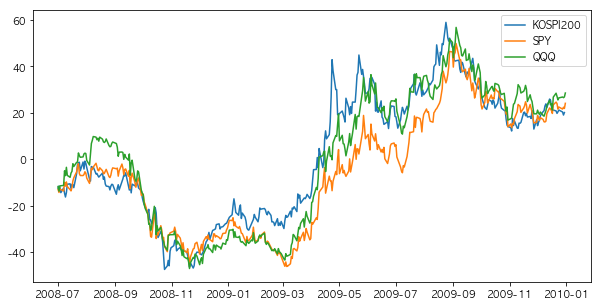

In [165]:
fig = plt.figure(figsize=(10,5))
fig.tight_layout()
subplot = fig.add_subplot(1,1,1)

for k, v in stock_store.std_dict.items():
    if (k in ["KS200"]):
        name = v['stock_name']
        ticker_data = v['data']['2008-07-01':'2009-12-31']
        subplot.plot(ticker_data['prev_rate180'], label=name)
        subplot.legend()
for k, v in stock_store.ticker_dict.items():
    if (k in ["005930.KS", "064350.KS", "102110.KS", "SPY", "QQQ"]):
        name = v['stock_name']
        ticker_data = v['data']['2008-07-01':'2009-12-31']
        subplot.plot(ticker_data['prev_rate180'], label=name)
        subplot.legend()
plt.show()

## 차트 - 100기준 수익률

2021-10-04 11:10:57,660 - DEBUG - update_title_pos
2021-10-04 11:10:57,723 - DEBUG - update_title_pos
2021-10-04 11:10:57,763 - DEBUG - update_title_pos
2021-10-04 11:10:57,784 - DEBUG - update_title_pos


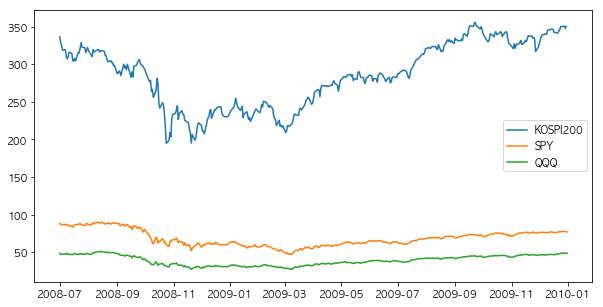

In [164]:
fig = plt.figure(figsize=(10,5))
fig.tight_layout()
subplot = fig.add_subplot(1,1,1)

for k, v in stock_store.std_dict.items():
    if (k in ["KS200"]):
        name = v['stock_name']
        ticker_data = v['data']['2008-07-01':'2009-12-31']
        subplot.plot(ticker_data['relative_value'], label=name)
        subplot.legend()
for k, v in stock_store.ticker_dict.items():
    if (k in ["005930.KS", "064350.KS", "102110.KS", "SPY", "QQQ"]):
        name = v['stock_name']
        ticker_data = v['data']['2008-07-01':'2009-12-31']
        subplot.plot(ticker_data['relative_value'], label=name)
        subplot.legend()
plt.show()

## 차트 - 개별 종목 가격, 이동평균

2021-10-04 10:55:52,681 - DEBUG - update_title_pos
2021-10-04 10:55:52,760 - DEBUG - update_title_pos
2021-10-04 10:55:52,794 - DEBUG - update_title_pos
2021-10-04 10:55:52,817 - DEBUG - update_title_pos


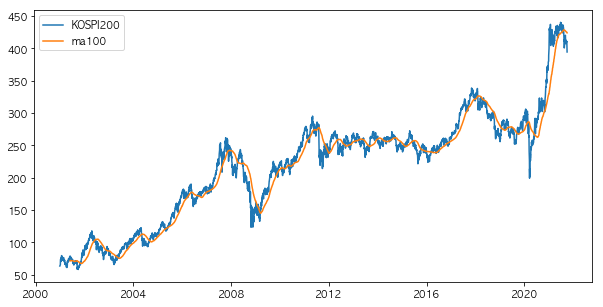

In [161]:
fig = plt.figure(figsize=(10,5))
fig.tight_layout()
subplot = fig.add_subplot(1,1,1)
    
code = "KS200"
name = stock_store.std_dict[code]['stock_name']
ticker_data = stock_store.std_dict[code]['data']
subplot.plot(ticker_data['Close'], label=name)
#subplot.plot(ticker_data['ma5'], label='ma5')
#subplot.plot(ticker_data['ma25'], label='ma25')
#subplot.plot(ticker_data['ma50'], label='ma50')
subplot.plot(ticker_data['ma100'], label='ma100')
subplot.legend()
plt.show()

2021-09-24 21:30:25,792 - DEBUG - update_title_pos
2021-09-24 21:30:25,852 - DEBUG - update_title_pos
2021-09-24 21:30:25,886 - DEBUG - update_title_pos
2021-09-24 21:30:25,906 - DEBUG - update_title_pos


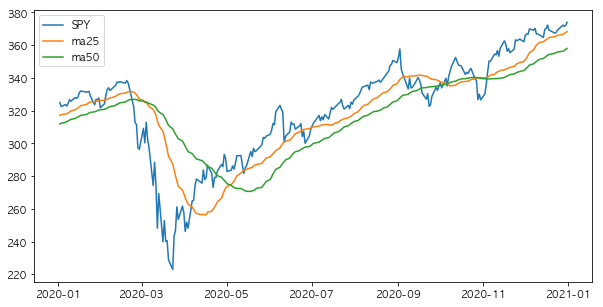

In [56]:
fig = plt.figure(figsize=(10,5))
fig.tight_layout()
subplot = fig.add_subplot(1,1,1)
    
code = "SPY"
name = stock_store.ticker_dict[code]['stock_name']
ticker_data = stock_store.ticker_dict[code]['data']
subplot.plot(ticker_data['Close'], label=name)
#subplot.plot(ticker_data['ma5'], label='ma5')
subplot.plot(ticker_data['ma25'], label='ma25')
subplot.plot(ticker_data['ma50'], label='ma50')
#subplot.plot(ticker_data['ma100'], label='ma100')
subplot.legend()
plt.show()

,High,Low,Open,Close,Volume,Adj Close,prev_close01,prev_close180,prev_rate180,relative_value,ma5,ma25,ma50,ma100
2020-01-02,2185,2130,2135,2180,131658,2180,2115,2700,-19.259259,100.000000,2111.0,2144.8,2209.3,2191.4
2020-01-03,2190,2145,2160,2160,107168,2160,2180,2700,-20.000000,99.082569,2121.0,2143.2,2206.8,2192.1


# 자산 관리 - 종목 매수, 매도

In [100]:
class Stock:
    def __init__(self, code):
        self.code = code
        self.stock_name = stock_store.get_stock_name(code)
        self.count = 0
        self.buy_price = 0
        self.buy_atr20 = 0
        self.highest_price = 0
        self.price = 0 # current price
        self.ammount = 0
        
    def get_profit_percent(self):
        p = (self.price-self.buy_price)/self.buy_price*100
        return round(p, 2)
    
    def get_profit_amount(self):
        return self.amount - self.buy_price*self.count
        
    def buy(self, count, price, atr20):
        self.count += count
        self.buy_price = price
        self.buy_atr20 = atr20
        self.price = price
        self.apply(price)
        
    def sell(self, count, price):
        self.count -= count
        self.price = price
        self.apply(price)
        
    def apply(self, price):
        self.price = price
        if (price > self.highest_price):
            self.highest_price = price
        self.amount = self.count * self.price
        
class Asset:
    def __init__(self, cash):
        self.stocks = { }
        self.cash = cash
        self.total = cash
    
    def get_stock_count(self):
        return len(self.stocks)
    
    def buy(self, code, count, price, atr20):
        stock = self.get_stock(code)
        
        amount = count * price
        self.cash -= amount # TODO cash 부족시
        stock.buy(count, price, atr20)
        self.eval()
        
    def get_buy_count(self, price):
        count = math.floor(self.cash / price)
        return count
    
    def sell(self, code, count, price):
        if (not self.is_stock(code)):
            print("Asset.sell(): stock not exist", code)
            return      
        stock = self.get_stock(code)
        if (count > stock.count):
            print("Asset.sell(): count=%d > stock.count=%d", count, stock.count)
            return
        
        amount = count * price
        self.cash += amount
        stock.sell(count, price)
        
        if (stock.count == 0):
            del self.stocks[code]
        self.eval()
        
    def sell_all(self, code, price):
        if (not self.is_stock(code)):
            print("Asset.sell(): stock not exist", code)
            return

        stock = self.get_stock(code)
        count = stock.count
        amount = count * price
        stock.sell(count, price)
        self.cash += amount
        
        if (stock.count == 0):
            del self.stocks[code]
        self.eval()
    
    def apply(self, code, price):
        if (self.is_stock(code)):
            stock = self.get_stock(code)
            stock.apply(price)
            self.eval()
        
    def get_stock(self, code):
        if code in self.stocks:
            return self.stocks[code]
        else:
            stock = Stock(code)
            self.stocks[code] = stock;
            return stock
        
    def is_stock(self, code):
        if code in self.stocks:
            return True
        return False
        
    def eval(self):
        stock_total = 0
        for k, v in self.stocks.items():
            stock_total += v.amount
        self.total = stock_total + self.cash
        return self.total
    
    def display(self):
        cash_percent = round(self.cash/self.total*100,2)
        log.info("Asset.display(): total=%d cash=%d cash_percent=%.2f", self.total, self.cash, cash_percent)
        for k, v in self.stocks.items():
            log.info("     code=%s stock_name=%s count=%d price=%.2f amount=%d highest_price=%.2f profit_percent=%.2f", \
                     v.code, v.stock_name, v.count, v.price, v.amount, v.highest_price, v.get_profit_percent())
            #print("    ", "code=", v.code, "stock_name=", v.stock_name, \
            #      "count=", v.count, "price=", v.price, "amount=", v.amount, \
            #      "highest_price=", v.highest_price, \
            #      "profit_percent=", v.get_profit_percent())


In [7]:
code = "005930.KS"
asset = Asset(10000000)
asset.buy(code, 10, 70000, 1000)
asset.apply(code, 80000)
asset.sell(code, 5, 90000)
asset.display()

2021-10-01 13:42:36,554 - INFO - Asset.display(): total=10200000 cash=9750000 cash_percent=95.59
2021-10-01 13:42:36,555 - INFO -      code=005930.KS stock_name=삼성전자 count=5 price=90000.00 amount=450000 highest_price=90000.00 profit_percent=28.57


# 종목 이벤트 이력

In [6]:
UNKNOWN_TREND = 0
DOWN_TREND = -1
UP_TREND = 1
class StockHistory:
    def __init__(self, code):
        self.code = code
        self.name = stock_store.get_stock_name(code)
        self.trend = UNKNOWN_TREND
        self.event_histories = [ ]

class StockHistoryStore:
    def __init__(self):
        self.stock_histories = { }
        
    def get_stock_history(self, code):
        if code in self.stock_histories:
            return self.stock_histories[code]
        else:
            stock_history = StockHistory(code)
            self.stock_histories[code] = stock_history;
            return stock_history

# 시스템

In [23]:
batch_data = system.make_batch_data('2020-01-02')
batch_data.head()

,Change,Close,High,Low,Open,Volume,ata20,atr20,code,ma100,ma25,ma5,ma50,prev_close01,prev_close180,prev_rate180,relative_value,ta,tr,Adj Close
2020-01-02,-0.0116,290.350000,294.570000,289.960000,294.190000,66160000.0,2.157121e+10,2.828000,KS200,273.872300,285.2296,293.476000,282.926000,295.200000,272.370000,6.60,100.0,1.920956e+10,4.610000,NaN
2020-01-02,NaN,324.869995,324.890015,322.529999,323.540009,59151200.0,1.926501e+10,1.770502,SPY,303.023599,317.1020,322.595996,311.817599,321.079987,298.799988,8.72,100.0,1.921645e+10,2.360016,316.836670
2020-01-02,NaN,216.160004,216.160004,213.979996,214.399994,30969400.0,4.323186e+09,1.416002,QQQ,196.028200,207.6628,213.538000,203.351800,212.210007,190.009995,13.76,100.0,6.694346e+09,2.180008,214.416458


In [26]:
batch_data[(batch_data['Close'] > system.MIN_STOCK_PRICE) &\
            (batch_data['ma25'] > batch_data['ma50']) &\
            (batch_data['prev_rate180'] >= 0)]

,Change,Close,High,Low,Open,Volume,ata20,atr20,code,ma100,ma25,ma5,ma50,prev_close01,prev_close180,prev_rate180,relative_value,ta,tr,Adj Close


In [102]:
class LTHM: # Long Trend High Momentum
    def __init__(self, stock_store, max_percent=10, cash=100000000): # 1억원
        self.MAX_POSITION_PERCENT = max_percent # 전체 자산 대비 종목별 최대 비중
        self.RISK_PERCENT = 2 # 손실 위험
        self.MIN_TRADING_AMOUNT = 60 * 1000 * 1000 * 1200 # 6백억
        self.MIN_STOCK_PRICE = 6000 # 6천원 이상
        self.ATR_MULTIPLY = 2 # stop loss=ATR*ATR_MULTIPLY
        self.PROFIT_RESERVE_PERCENT = 15
        
        self.STOP_LOSS_PERCENT = 1
        self.MIN_PREV_RATE180 = 0
        self.MAX_BUY_PER_DAY = 2
        self.stock_store = stock_store
        self.asset = Asset(cash)
        self.data = pd.DataFrame(columns=['total', 'cash'])
        self.stock_history_store = StockHistoryStore()
        self.action_histories = [ ]
        
    def set_asset(self, asset):
        self.asset = asset
    def set_data(self, data):
        self.data = data
    
    # 모든 종목에 대해 idx row를 합쳐 batch_data 생성
    def make_batch_data(self, idx):
        batch_data = pd.DataFrame()
        for k, v in stock_store.ticker_dict.items():
            if (idx in v['data'].index):
                copy = v['data'].loc[idx].copy()
                copy['code'] = k
                batch_data = batch_data.append(copy)
        return batch_data
    
    def filter_batch_data(self, batch_data):  
        if (len(batch_data) == 0):
            return batch_data
        
        # 종목 거래 금액, 주가, 이동 평균 filter
        filtered_data = batch_data[\
            (batch_data['ata20'] > self.MIN_TRADING_AMOUNT) &\
            (batch_data['Close'] > self.MIN_STOCK_PRICE) &\
            (batch_data['ma25'] > batch_data['ma50']) &\
            (batch_data['prev_rate180'] >= 0)]
        return filtered_data
    
    def prioritize_batch_data(self, batch_data):
        return batch_data.sort_values(by='prev_rate180', ascending=False)
    
    def backtest(self):
        ticker_data = stock_store.std_dict['005930.KS']['data'] # idx 가져오기 위해 삼성전자 종목 사용
        for idx, row in ticker_data.iterrows():
            self.apply(idx)

        add_relative_value(self.data, 'total') # total 값을 이용하여 relative_value 컬럼 추가
        return
    
    def backtest(self, year):
        start_idx = f"{year}-01-01"
        end_idx = f"{year}-12-31"
        ticker_data = stock_store.std_dict['005930.KS']['data']
        ticker_data = ticker_data[start_idx:end_idx]
        for idx, row in ticker_data.iterrows():
            log.debug("LTHM.backtest(): idx=%s", idx)
            self.apply(idx)

        add_relative_value(self.data, 'total') # total 값을 이용하여 relative_value 컬럼 추가
        return
    
    def apply(self, idx):       
        # 신규 종목 체크
        buy_per_day = 0
        if (self.is_ks200_satisfied(idx)):
            batch_data = self.make_batch_data(idx)
            batch_data = self.filter_batch_data(batch_data)
            batch_data = self.prioritize_batch_data(batch_data)
            #log.debug("LTHM.apply(): batch_data03 idx=%s batch_data_len=%d", idx, len(batch_data))
            for idx, row in batch_data.iterrows():
                if (self.get_available_position_percent() < self.MAX_POSITION_PERCENT/2): # 5% 이하면 break
                    break
#                if (not self.is_available_position()): # 10% 이하면 break
#                    break
                code = row['code']
                if (self.apply_buy(idx, code, row)):
                    buy_per_day += 1
                    if (buy_per_day >= self.MAX_BUY_PER_DAY):
                        break
            
        # 보유 종목 체크
        for k in list(self.asset.stocks.keys()):
            code = k
            ticker_data = stock_store.ticker_dict[code]['data']
            if (idx in ticker_data.index):
                row = ticker_data.loc[idx]
                self.asset.apply(code, row['Close'])
                self.apply_sell(idx, code, row)
            else:
                log.debug("LTHM.apply(): ticker_data index not found, ignored: idx=%s code=%s", idx, code)

        self.data = self.data.append(pd.Series({'total':self.asset.total, 'cash':self.asset.cash}, index=self.data.columns, name=idx))
    
    def apply_buy(self, idx, code, row, use_risk=True):
        stock_history = self.stock_history_store.get_stock_history(code)        
        price = row['Close']
        atr20 = row['atr20']
        #self.asset.apply(code, price)
        
        # Check buy
        if (not self.asset.is_stock(code) and \
            self.is_uptrend(stock_history, idx, row)):
            return self.buy_position(idx, code, row, use_risk)
        return False

    def apply_sell(self, idx, code, row):                
        # Check sell
        if (self.asset.is_stock(code)):
            stock = self.asset.get_stock(code)
            if (self.is_stop_loss(stock, row) or self.is_profit_reserve(stock, row)):
                return self.sell_position(idx, code, row)
        return False

    ### Common ###
    # 포지션 매수
    def buy_position(self, idx, code, row, use_risk=True):
        price = row['Close']
        atr20 = row['atr20']
        
        # Check buy
        if (not self.asset.is_stock(code)):
            count = 0
            if (use_risk):
                count = self.get_buy_count_risk(price, atr20)
            else:
                count = self.get_buy_count_cash(price)
            if (count > 0):
                self.buy_count(idx, code, row, count)
                return True
        return False

    # 포지션 매도
    def sell_position(self, idx, code, row):                
        # Check sell
        if (self.asset.is_stock(code)):
            stock = self.asset.get_stock(code)
            count = stock.count
            self.sell_count(idx, code, row, count)
            return True
        return False
    
    # 부분 매수
    def buy_count(self, idx, code, row, count):
        stock_history = self.stock_history_store.get_stock_history(code)
        price = row['Close']
        atr20 = row['atr20']
        
        action = { "name": "buy", "idx": idx.strftime('%Y-%m-%d'), \
                  "code": code, "stock_name": stock_history.name, "count": count, "price": price, \
                 "prev_rate180": row['prev_rate180']}
        log.info("action=%s", str(action))
        self.asset.buy(code, count, price, atr20)
        self.asset.display()
        self.action_histories.append(action)
    
    # 부분 매도
    def sell_count(self, idx, code, row, count):
        stock_history = self.stock_history_store.get_stock_history(code)
        price = row['Close']
        atr20 = row['atr20']

        stock = self.asset.get_stock(code)
        action = {"name": "sell", \
                  "idx": idx.strftime('%Y-%m-%d'), \
                  "code": code, \
                  "stock_name": stock_history.name, \
                  "count": count, \
                  "price": price, \
                  "buy_price": stock.buy_price, \
                  "profit_percent": stock.get_profit_percent()}
        log.info("action=%s", str(action))
        self.asset.sell(code, count, price)
        self.asset.display()
        self.action_histories.append(action)
        
    def is_ks200_satisfied(self, idx):
        code = "KS200"
        ticker_data = stock_store.std_dict[code]['data']
        row = ticker_data.loc[idx]
        if (row['Close'] > row['ma100']):
            return True
        return False
    
    # 총자산 대비 위험 비율
    def get_buy_count_risk(self, price, atr20):
        #if (not self.is_available_position()):
        #    return 0
        position_limit = self.get_position_limit() # 포지션 최대 금액
        position_risk_amount = math.floor(self.asset.total * self.RISK_PERCENT / 100) # 포지션 위험 부담 금액
        stop_loss_amount = atr20*self.ATR_MULTIPLY # 주당 위험 부담 금액
        
        # buy count(포지션 크기) 계산
        buy_count = math.floor(position_risk_amount / stop_loss_amount)
        position_amount = buy_count * price
        if (position_amount > position_limit):
            position_amount = position_limit
            buy_count = math.floor(position_amount / price)
            
        # cash limit
        cash_limit = self.get_cash_limit()
        if (position_amount > cash_limit):
            position_amount = cash_limit
            buy_count = math.floor(position_amount / price)
        #if (position_amount > self.asset.cash):
        #    buy_count = 0
        log.debug("LTHM.get_buy_count(): buy_count=%d position_amount=%d total=%d cash=%d position_limit=%d cash_limit=%d", \
                  buy_count, position_amount, self.asset.total, self.asset.cash, position_limit, cash_limit)
        #print(f"LTHM.get_buy_count(): buy_count={buy_count} position_amount={position_amount} \
        #    total={self.asset.total} cash={self.asset.cash} position_limit={position_limit} cash_limit={cash_limit}")
        return buy_count
    
    # 총자산 대비 금액 비율
    def get_buy_count_cash(self, price):       
        if (not self.is_available_position()):
            return 0
        position_cash = self.asset.total * self.MAX_POSITION_PERCENT / 100
        log.debug("LTHM.get_buy_count(): position_cash=%d", position_cash)
        return math.floor(position_cash / price)
    
    def get_position_limit(self):
        return math.floor(self.asset.total*self.MAX_POSITION_PERCENT/100)
    
    def get_cash_limit(self):
        one_percent_amount = self.asset.total*0.01
        if (self.asset.cash <= one_percent_amount):
            return 0
        return self.asset.cash - one_percent_amount
    
    def get_available_position_percent(self):
        return self.asset.cash/self.asset.total*100
    
    def is_available_position(self):
        if (self.asset.cash/self.asset.total*100 >= self.MAX_POSITION_PERCENT):
            return True
        return False
    
    def is_uptrend(self, stock_history, idx, row):
        if (row['ma25'] > row['ma50']):
            stock_history.trend = UP_TREND
            return True
        return False        

    def is_downtrend(self, stock_history, idx, row):
        if (row['ma25'] < row['ma50']):
            stock_history.trend = DOWN_TREND
            return True
        return False
    
    def is_stop_loss(self, stock, row):
        price = row['Close']
        #if (price < stock.buy_price and ((stock.buy_price-price)/stock.buy_price*100 >= self.STOP_LOSS_PERCENT)):
        #    print("LTHM.is_stop_loss():", "code=", stock.code, "stock_name=", stock.stock_name, \
        #          "buy_price=", stock.buy_price, "price=", price, "buy_atr20=", stock.buy_atr20)
        #    return True
        if (price < stock.buy_price and ((stock.buy_price-price) > stock.buy_atr20*self.ATR_MULTIPLY)):
            log.debug("LTHM.is_stop_loss(): code=%s stock_name=%s buy_price=%d price=%d buy_atr20=%d", \
                      stock.code, stock.stock_name, stock.buy_price, price, stock.buy_atr20)
            return True
        return False

    def is_profit_reserve(self, stock, row):
        price = row['Close']
        if (price < stock.highest_price*(1-self.PROFIT_RESERVE_PERCENT/100)):
            log.debug("LTHM.is_profit_reserve(): code=%s stock_name=%s buy_price=%d price=%d highest_price=%d", \
                      stock.code, stock.stock_name, stock.buy_price, price, stock.highest_price)
            return True
        return False
    
    def on_gold_cross(self, stock_history, idx, row):
        code = stock_history.code
        stock_name = stock_history.name
        if (stock_history.trend != UP_TREND and row['ma25'] > row['ma50']):
            stock_history.trend = UP_TREND
            event = { "idx": idx.strftime('%Y-%m-%d'), "code": code, "stock_name": stock_name, "name": "uptrend"}
            stock_history.event_histories.append(event)
            print("event:", event)
            return True
        return False
    
    def on_dead_cross(self, stock_history, idx, row):
        code = stock_history.code
        stock_name = stock_history.name
        if (stock_history.trend != DOWN_TREND and row['ma25'] < row['ma50']):
            stock_history.trend = DOWN_TREND
            event = { "idx": idx.strftime('%Y-%m-%d'), "code": code, "stock_name": stock_name, "name": "downtrend"}
            stock_history.event_histories.append(event)
            print("event:", event)
            return True
        return False

    # 차트
    def show_chart(self):
        fig = plt.figure(figsize=(10,5))
        fig.tight_layout()
        subplot = fig.add_subplot(1,1,1)

        for k, v in stock_store.std_dict.items():
            if (k in ["KS11", "KS200", "005930.KS"]):
                name = v['stock_name']
                std_data = v['data']
                subplot.plot(std_data['relative_value'], label=name)
                subplot.legend()

        for k, v in stock_store.ticker_dict.items():
            if (k in ["SPY", "QQQ"]):
                name = v['stock_name']
                ticker_data = v['data']
                subplot.plot(ticker_data['relative_value'], label=name)
                subplot.legend()

        #for k, v in system_dict.items():
        #    if (k in ["LTHM"]):
        #        name = v['name']
        #        system_data = v['data']
        #        subplot.plot(system_data['relative_value'], label=name)
        #        subplot.legend()
        ##plt.show()
        #return subplot

        name = 'LTHM'
        ticker_data = self.data
        subplot.plot(ticker_data['relative_value'], label=name)
        subplot.legend()
        #plt.show()
        return subplot

## 시스템 - max_percent=10

In [159]:
stock_store = StockStore(ticker_dict_all)
system = LTHM(stock_store, max_percent=10)

for year in range(2020,2021):
    stock_store.load_std_dict(year)
    stock_store.load_ticker_dict(year)
    system.backtest(year)

2021-09-25 11:11:12,487 - DEBUG - StockStore.pad_stock_data(): code=SPY stock_name=Unknown stock_data len=253 std_data len=248 start_time=2020-01-01 09:00:00
2021-09-25 11:11:13,551 - DEBUG - StockStore.pad_stock_data(): code=365550.KS stock_name=ESR켄달스퀘어리츠 stock_data len=5 std_data len=248 start_time=2020-01-01 09:00:00
2021-09-25 11:11:14,763 - DEBUG - StockStore.pad_stock_data(): code=344820.KS stock_name=KCC글라스 stock_data len=235 std_data len=248 start_time=2020-01-01 09:00:00
2021-09-25 11:11:17,408 - DEBUG - StockStore.pad_stock_data(): code=326030.KS stock_name=SK바이오팜 stock_data len=124 std_data len=248 start_time=2020-01-01 09:00:00
2021-09-25 11:11:19,136 - DEBUG - StockStore.pad_stock_data(): code=339770.KS stock_name=교촌에프앤비 stock_data len=34 std_data len=248 start_time=2020-01-01 09:00:00
2021-09-25 11:11:20,944 - DEBUG - StockStore.pad_stock_data(): code=353200.KS stock_name=대덕전자 stock_data len=154 std_data len=248 start_time=2020-01-01 09:00:00
2021-09-25 11:11:25,343 - DE

2021-09-25 11:12:40,746 - INFO -      code=000660.KS stock_name=SK하이닉스 count=105 price=98200.00 amount=10311000 highest_price=100500.00 profit_percent=3.70
2021-09-25 11:12:40,747 - INFO -      code=180640.KS stock_name=한진칼 count=250 price=41500.00 amount=10375000 highest_price=41900.00 profit_percent=3.88
2021-09-25 11:12:40,747 - INFO -      code=005930.KS stock_name=삼성전자 count=180 price=59000.00 amount=10620000 highest_price=60000.00 profit_percent=6.31
2021-09-25 11:12:40,748 - INFO -      code=009150.KS stock_name=삼성전기 count=78 price=133500.00 amount=10413000 highest_price=135500.00 profit_percent=4.71
2021-09-25 11:12:40,749 - INFO -      code=004770.KS stock_name=써니전자 count=1693 price=6040.00 amount=10225720 highest_price=6180.00 profit_percent=0.50
2021-09-25 11:12:40,749 - INFO -      code=006400.KS stock_name=삼성SDI count=37 price=268500.00 amount=9934500 highest_price=268500.00 profit_percent=0.00
2021-09-25 11:12:40,754 - DEBUG - LTHM.backtest(): idx=2020-01-17 00:00:00
2021

2021-09-25 11:13:10,174 - INFO -      code=009150.KS stock_name=삼성전기 count=78 price=134500.00 amount=10491000 highest_price=137000.00 profit_percent=5.49
2021-09-25 11:13:10,175 - INFO -      code=006400.KS stock_name=삼성SDI count=37 price=283500.00 amount=10489500 highest_price=286000.00 profit_percent=5.59
2021-09-25 11:13:10,176 - INFO -      code=068270.KS stock_name=셀트리온 count=60 price=172058.83 amount=10323529 highest_price=173039.22 profit_percent=1.74
2021-09-25 11:13:10,176 - INFO -      code=035720.KS stock_name=카카오 count=307 price=33100.00 amount=10161700 highest_price=33200.00 profit_percent=0.30
2021-09-25 11:13:10,177 - INFO -      code=035420.KS stock_name=NAVER count=56 price=178500.00 amount=9996000 highest_price=178500.00 profit_percent=0.00
2021-09-25 11:13:10,178 - INFO -      code=090430.KS stock_name=아모레퍼시픽 count=51 price=194500.00 amount=9919500 highest_price=194500.00 profit_percent=0.00
2021-09-25 11:13:10,184 - DEBUG - LTHM.backtest(): idx=2020-01-29 00:00:00
2

2021-09-25 11:14:38,555 - INFO - action={'name': 'sell', 'idx': '2020-02-28', 'code': '008770.KS', 'stock_name': '호텔신라', 'count': 82, 'price': 80300, 'buy_price': 89500.0, 'profit_percent': -10.28}
2021-09-25 11:14:38,556 - INFO - Asset.display(): total=103265631 cash=25661831 cash_percent=24.85
2021-09-25 11:14:38,557 - INFO -      code=180640.KS stock_name=한진칼 count=250 price=67200.00 amount=16800000 highest_price=67200.00 profit_percent=68.21
2021-09-25 11:14:38,558 - INFO -      code=005930.KS stock_name=삼성전자 count=180 price=54200.00 amount=9756000 highest_price=62400.00 profit_percent=-2.34
2021-09-25 11:14:38,558 - INFO -      code=009150.KS stock_name=삼성전기 count=78 price=126000.00 amount=9828000 highest_price=146000.00 profit_percent=-1.18
2021-09-25 11:14:38,559 - INFO -      code=006400.KS stock_name=삼성SDI count=37 price=295000.00 amount=10915000 highest_price=343500.00 profit_percent=9.87
2021-09-25 11:14:38,560 - INFO -      code=068270.KS stock_name=셀트리온 count=60 price=1666

2021-09-25 11:14:38,657 - INFO - action={'name': 'sell', 'idx': '2020-03-18', 'code': '068270.KS', 'stock_name': '셀트리온', 'count': 60, 'price': 153921.5625, 'buy_price': 169117.640625, 'profit_percent': -8.99}
2021-09-25 11:14:38,658 - INFO - Asset.display(): total=101340525 cash=101340525 cash_percent=100.00
2021-09-25 11:14:38,661 - DEBUG - LTHM.backtest(): idx=2020-03-19 00:00:00
2021-09-25 11:14:38,664 - DEBUG - LTHM.backtest(): idx=2020-03-20 00:00:00
2021-09-25 11:14:38,668 - DEBUG - LTHM.backtest(): idx=2020-03-23 00:00:00
2021-09-25 11:14:38,672 - DEBUG - LTHM.backtest(): idx=2020-03-24 00:00:00
2021-09-25 11:14:38,676 - DEBUG - LTHM.backtest(): idx=2020-03-25 00:00:00
2021-09-25 11:14:38,679 - DEBUG - LTHM.backtest(): idx=2020-03-26 00:00:00
2021-09-25 11:14:38,682 - DEBUG - LTHM.backtest(): idx=2020-03-27 00:00:00
2021-09-25 11:14:38,686 - DEBUG - LTHM.backtest(): idx=2020-03-30 00:00:00
2021-09-25 11:14:38,689 - DEBUG - LTHM.backtest(): idx=2020-03-31 00:00:00
2021-09-25 11:1

2021-09-25 11:14:54,092 - INFO -      code=008350.KS stock_name=남선알미늄 count=1589 price=6340.00 amount=10074260 highest_price=6340.00 profit_percent=0.00
2021-09-25 11:14:54,118 - DEBUG - LTHM.get_buy_count(): buy_count=419 position_amount=10075447 total=100754475 cash=50830565 position_limit=10075447 cash_limit=49823020
2021-09-25 11:14:54,119 - INFO - action={'name': 'buy', 'idx': '2020-05-29', 'code': '003000.KS', 'stock_name': '부광약품', 'count': 419, 'price': 24000.0, 'prev_rate180': 85.42}
2021-09-25 11:14:54,146 - INFO - Asset.display(): total=100754475 cash=40774565 cash_percent=40.47
2021-09-25 11:14:54,146 - INFO -      code=019170.KS stock_name=신풍제약 count=491 price=20450.00 amount=10040950 highest_price=20600.00 profit_percent=-0.73
2021-09-25 11:14:54,147 - INFO -      code=005690.KS stock_name=파미셀 count=427 price=22500.00 amount=9607500 highest_price=23700.00 profit_percent=-5.06
2021-09-25 11:14:54,148 - INFO -      code=180640.KS stock_name=한진칼 count=108 price=93300.00 amoun

2021-09-25 11:15:03,762 - INFO -      code=036570.KS stock_name=엔씨소프트 count=12 price=810000.00 amount=9720000 highest_price=810000.00 profit_percent=0.00
2021-09-25 11:15:03,762 - INFO -      code=006400.KS stock_name=삼성SDI count=26 price=370000.00 amount=9620000 highest_price=370000.00 profit_percent=0.00
2021-09-25 11:15:03,769 - DEBUG - LTHM.backtest(): idx=2020-06-03 00:00:00
2021-09-25 11:15:08,932 - DEBUG - LTHM.backtest(): idx=2020-06-04 00:00:00
2021-09-25 11:15:13,517 - DEBUG - LTHM.backtest(): idx=2020-06-05 00:00:00
2021-09-25 11:15:18,105 - DEBUG - LTHM.backtest(): idx=2020-06-08 00:00:00
2021-09-25 11:15:22,925 - DEBUG - LTHM.backtest(): idx=2020-06-09 00:00:00
2021-09-25 11:15:27,512 - DEBUG - LTHM.backtest(): idx=2020-06-10 00:00:00
2021-09-25 11:15:32,000 - DEBUG - LTHM.backtest(): idx=2020-06-11 00:00:00
2021-09-25 11:15:36,458 - DEBUG - LTHM.backtest(): idx=2020-06-12 00:00:00
2021-09-25 11:15:40,934 - DEBUG - LTHM.backtest(): idx=2020-06-15 00:00:00
2021-09-25 11:15:

2021-09-25 11:15:50,110 - INFO -      code=336260.KS stock_name=두산퓨얼셀 count=473 price=23120.83 amount=10936153 highest_price=23120.83 profit_percent=0.00
2021-09-25 11:15:50,116 - DEBUG - LTHM.backtest(): idx=2020-06-17 00:00:00
2021-09-25 11:15:54,715 - DEBUG - LTHM.backtest(): idx=2020-06-18 00:00:00
2021-09-25 11:15:59,176 - DEBUG - LTHM.backtest(): idx=2020-06-19 00:00:00
2021-09-25 11:16:03,650 - DEBUG - LTHM.backtest(): idx=2020-06-22 00:00:00
2021-09-25 11:16:08,363 - DEBUG - LTHM.backtest(): idx=2020-06-23 00:00:00
2021-09-25 11:16:13,521 - DEBUG - LTHM.backtest(): idx=2020-06-24 00:00:00
2021-09-25 11:16:18,646 - DEBUG - LTHM.is_profit_reserve(): code=019170.KS stock_name=신풍제약 buy_price=20600 price=29000 highest_price=34300
2021-09-25 11:16:18,646 - INFO - action={'name': 'sell', 'idx': '2020-06-24', 'code': '019170.KS', 'stock_name': '신풍제약', 'count': 491, 'price': 29000, 'buy_price': 20600.0, 'profit_percent': 40.78}
2021-09-25 11:16:18,647 - INFO - Asset.display(): total=114

2021-09-25 11:16:28,814 - DEBUG - LTHM.is_profit_reserve(): code=003000.KS stock_name=부광약품 buy_price=24000 price=30681 highest_price=37363
2021-09-25 11:16:28,815 - INFO - action={'name': 'sell', 'idx': '2020-06-26', 'code': '003000.KS', 'stock_name': '부광약품', 'count': 419, 'price': 30681.818359375, 'buy_price': 24000.0, 'profit_percent': 27.84}
2021-09-25 11:16:28,816 - INFO - Asset.display(): total=113781858 cash=15558484 cash_percent=13.67
2021-09-25 11:16:28,816 - INFO -      code=026890.KS stock_name=디피씨 count=904 price=10150.00 amount=9175600 highest_price=11200.00 profit_percent=-9.38
2021-09-25 11:16:28,817 - INFO -      code=008350.KS stock_name=남선알미늄 count=1589 price=6340.00 amount=10074260 highest_price=6400.00 profit_percent=0.00
2021-09-25 11:16:28,817 - INFO -      code=035720.KS stock_name=카카오 count=190 price=54900.00 amount=10431000 highest_price=56500.00 profit_percent=3.98
2021-09-25 11:16:28,818 - INFO -      code=036570.KS stock_name=엔씨소프트 count=12 price=912000.00 am

2021-09-25 11:17:07,683 - DEBUG - LTHM.backtest(): idx=2020-07-09 00:00:00
2021-09-25 11:17:12,249 - DEBUG - LTHM.backtest(): idx=2020-07-10 00:00:00
2021-09-25 11:17:16,765 - DEBUG - LTHM.backtest(): idx=2020-07-13 00:00:00
2021-09-25 11:17:21,384 - DEBUG - LTHM.backtest(): idx=2020-07-14 00:00:00
2021-09-25 11:17:25,932 - DEBUG - LTHM.backtest(): idx=2020-07-15 00:00:00
2021-09-25 11:17:30,441 - DEBUG - LTHM.backtest(): idx=2020-07-16 00:00:00
2021-09-25 11:17:34,945 - DEBUG - LTHM.is_profit_reserve(): code=003090.KS stock_name=대웅 buy_price=26600 price=22550 highest_price=26600
2021-09-25 11:17:34,945 - INFO - action={'name': 'sell', 'idx': '2020-07-16', 'code': '003090.KS', 'stock_name': '대웅', 'count': 342, 'price': 22550, 'buy_price': 26600.0, 'profit_percent': -15.23}
2021-09-25 11:17:34,946 - INFO - Asset.display(): total=133985661 cash=12547821 cash_percent=9.37
2021-09-25 11:17:34,946 - INFO -      code=026890.KS stock_name=디피씨 count=904 price=17700.00 amount=16000800 highest_p

2021-09-25 11:17:48,794 - DEBUG - LTHM.backtest(): idx=2020-07-22 00:00:00
2021-09-25 11:17:53,357 - DEBUG - LTHM.backtest(): idx=2020-07-23 00:00:00
2021-09-25 11:17:57,863 - DEBUG - LTHM.is_profit_reserve(): code=036570.KS stock_name=엔씨소프트 buy_price=810000 price=811000 highest_price=995000
2021-09-25 11:17:57,863 - INFO - action={'name': 'sell', 'idx': '2020-07-23', 'code': '036570.KS', 'stock_name': '엔씨소프트', 'count': 12, 'price': 811000, 'buy_price': 810000.0, 'profit_percent': 0.12}
2021-09-25 11:17:57,864 - INFO - Asset.display(): total=169102116 cash=11500037 cash_percent=6.80
2021-09-25 11:17:57,865 - INFO -      code=026890.KS stock_name=디피씨 count=904 price=17150.00 amount=15503600 highest_price=18600.00 profit_percent=53.12
2021-09-25 11:17:57,866 - INFO -      code=035720.KS stock_name=카카오 count=190 price=65900.00 amount=12521000 highest_price=71100.00 profit_percent=24.81
2021-09-25 11:17:57,867 - INFO -      code=006400.KS stock_name=삼성SDI count=26 price=388000.00 amount=10

2021-09-25 11:18:11,707 - INFO - Asset.display(): total=155775307 cash=6566037 cash_percent=4.22
2021-09-25 11:18:11,708 - INFO -      code=026890.KS stock_name=디피씨 count=904 price=16750.00 amount=15142000 highest_price=18600.00 profit_percent=49.55
2021-09-25 11:18:11,709 - INFO -      code=035720.KS stock_name=카카오 count=190 price=65300.00 amount=12407000 highest_price=71100.00 profit_percent=23.67
2021-09-25 11:18:11,710 - INFO -      code=006400.KS stock_name=삼성SDI count=26 price=378000.00 amount=9828000 highest_price=394000.00 profit_percent=2.16
2021-09-25 11:18:11,710 - INFO -      code=007570.KS stock_name=일양약품 count=156 price=87000.00 amount=13572000 highest_price=97600.00 profit_percent=28.89
2021-09-25 11:18:11,711 - INFO -      code=336260.KS stock_name=두산퓨얼셀 count=473 price=44376.29 amount=20989984 highest_price=44376.29 profit_percent=91.93
2021-09-25 11:18:11,712 - INFO -      code=003000.KS stock_name=부광약품 count=356 price=35227.27 amount=12540909 highest_price=37772.73 p

2021-09-25 11:18:31,117 - INFO - Asset.display(): total=151549286 cash=1521163 cash_percent=1.00
2021-09-25 11:18:31,117 - INFO -      code=026890.KS stock_name=디피씨 count=904 price=17200.00 amount=15548800 highest_price=18850.00 profit_percent=53.57
2021-09-25 11:18:31,118 - INFO -      code=035720.KS stock_name=카카오 count=190 price=68700.00 amount=13053000 highest_price=71100.00 profit_percent=30.11
2021-09-25 11:18:31,119 - INFO -      code=006400.KS stock_name=삼성SDI count=26 price=397500.00 amount=10335000 highest_price=397500.00 profit_percent=7.43
2021-09-25 11:18:31,120 - INFO -      code=007570.KS stock_name=일양약품 count=156 price=84000.00 amount=13104000 highest_price=97600.00 profit_percent=24.44
2021-09-25 11:18:31,121 - INFO -      code=336260.KS stock_name=두산퓨얼셀 count=473 price=44867.18 amount=21222174 highest_price=45652.60 profit_percent=94.06
2021-09-25 11:18:31,121 - INFO -      code=003000.KS stock_name=부광약품 count=356 price=33636.36 amount=11974545 highest_price=37772.73 

2021-09-25 11:19:13,430 - INFO -      code=019170.KS stock_name=신풍제약 count=102 price=75100.00 amount=7660200 highest_price=78700.00 profit_percent=2.18
2021-09-25 11:19:13,431 - INFO -      code=007570.KS stock_name=일양약품 count=148 price=81300.00 amount=12032400 highest_price=81300.00 profit_percent=0.00
2021-09-25 11:19:13,435 - DEBUG - LTHM.backtest(): idx=2020-08-18 00:00:00
2021-09-25 11:19:18,169 - DEBUG - LTHM.get_buy_count(): buy_count=517 position_amount=11374000 total=168893649 cash=13706906 position_limit=16889364 cash_limit=12017970
2021-09-25 11:19:18,170 - INFO - action={'name': 'buy', 'idx': '2020-08-18', 'code': '000020.KS', 'stock_name': '동화약품', 'count': 517, 'price': 22000.0, 'prev_rate180': 206.41}
2021-09-25 11:19:18,193 - INFO - Asset.display(): total=168893649 cash=2332906 cash_percent=1.38
2021-09-25 11:19:18,194 - INFO -      code=026890.KS stock_name=디피씨 count=904 price=18000.00 amount=16272000 highest_price=20300.00 profit_percent=60.71
2021-09-25 11:19:18,194 -

2021-09-25 11:19:23,017 - INFO - action={'name': 'buy', 'idx': '2020-08-19', 'code': '004720.KS', 'stock_name': '팜젠사이언스', 'count': 805, 'price': 20300.0, 'prev_rate180': 250.0}
2021-09-25 11:19:23,043 - INFO - Asset.display(): total=163597283 cash=30668183 cash_percent=18.75
2021-09-25 11:19:23,044 - INFO -      code=035720.KS stock_name=카카오 count=190 price=75600.00 amount=14364000 highest_price=75600.00 profit_percent=43.18
2021-09-25 11:19:23,045 - INFO -      code=006400.KS stock_name=삼성SDI count=26 price=433000.00 amount=11258000 highest_price=488000.00 profit_percent=17.03
2021-09-25 11:19:23,045 - INFO -      code=285130.KS stock_name=SK케미칼 count=68 price=379000.00 amount=25772000 highest_price=436000.00 profit_percent=131.10
2021-09-25 11:19:23,046 - INFO -      code=006120.KS stock_name=SK디스커버리 count=208 price=71200.00 amount=14809600 highest_price=81300.00 profit_percent=51.65
2021-09-25 11:19:23,047 - INFO -      code=006280.KS stock_name=녹십자 count=66 price=281500.00 amount=1

2021-09-25 11:19:32,682 - INFO - Asset.display(): total=170326083 cash=1707586 cash_percent=1.00
2021-09-25 11:19:32,682 - INFO -      code=035720.KS stock_name=카카오 count=190 price=72900.00 amount=13851000 highest_price=75600.00 profit_percent=38.07
2021-09-25 11:19:32,683 - INFO -      code=285130.KS stock_name=SK케미칼 count=68 price=401500.00 amount=27302000 highest_price=436000.00 profit_percent=144.82
2021-09-25 11:19:32,683 - INFO -      code=006120.KS stock_name=SK디스커버리 count=208 price=69500.00 amount=14456000 highest_price=81300.00 profit_percent=48.03
2021-09-25 11:19:32,684 - INFO -      code=006280.KS stock_name=녹십자 count=66 price=283500.00 amount=18711000 highest_price=301500.00 profit_percent=20.38
2021-09-25 11:19:32,685 - INFO -      code=019170.KS stock_name=신풍제약 count=102 price=93200.00 amount=9506400 highest_price=93200.00 profit_percent=26.80
2021-09-25 11:19:32,685 - INFO -      code=007570.KS stock_name=일양약품 count=148 price=80700.00 amount=11943600 highest_price=81300

2021-09-25 11:19:51,308 - DEBUG - LTHM.is_profit_reserve(): code=011000.KS stock_name=진원생명과학 buy_price=14100 price=23700 highest_price=30850
2021-09-25 11:19:51,309 - INFO - action={'name': 'sell', 'idx': '2020-08-27', 'code': '011000.KS', 'stock_name': '진원생명과학', 'count': 764, 'price': 23700.0, 'buy_price': 14100.0, 'profit_percent': 68.09}
2021-09-25 11:19:51,309 - INFO - Asset.display(): total=174189997 cash=37564636 cash_percent=21.57
2021-09-25 11:19:51,310 - INFO -      code=035720.KS stock_name=카카오 count=190 price=82100.00 amount=15599000 highest_price=82100.00 profit_percent=55.49
2021-09-25 11:19:51,310 - INFO -      code=285130.KS stock_name=SK케미칼 count=68 price=402000.00 amount=27336000 highest_price=436000.00 profit_percent=145.12
2021-09-25 11:19:51,311 - INFO -      code=006280.KS stock_name=녹십자 count=66 price=267000.00 amount=17622000 highest_price=301500.00 profit_percent=13.38
2021-09-25 11:19:51,312 - INFO -      code=019170.KS stock_name=신풍제약 count=102 price=111500.00

2021-09-25 11:20:00,901 - INFO - action={'name': 'buy', 'idx': '2020-08-31', 'code': '006120.KS', 'stock_name': 'SK디스커버리', 'count': 171, 'price': 77400.0, 'prev_rate180': 244.77}
2021-09-25 11:20:00,924 - INFO - Asset.display(): total=171252599 cash=1742886 cash_percent=1.02
2021-09-25 11:20:00,924 - INFO -      code=035720.KS stock_name=카카오 count=190 price=81100.00 amount=15409000 highest_price=82100.00 profit_percent=53.60
2021-09-25 11:20:00,925 - INFO -      code=285130.KS stock_name=SK케미칼 count=68 price=393000.00 amount=26724000 highest_price=436000.00 profit_percent=139.63
2021-09-25 11:20:00,925 - INFO -      code=006280.KS stock_name=녹십자 count=66 price=264000.00 amount=17424000 highest_price=301500.00 profit_percent=12.10
2021-09-25 11:20:00,926 - INFO -      code=019170.KS stock_name=신풍제약 count=102 price=111000.00 amount=11322000 highest_price=114000.00 profit_percent=51.02
2021-09-25 11:20:00,927 - INFO -      code=007570.KS stock_name=일양약품 count=148 price=80000.00 amount=118

2021-09-25 11:20:29,131 - INFO -      code=006120.KS stock_name=SK디스커버리 count=171 price=75300.00 amount=12876300 highest_price=77400.00 profit_percent=-2.71
2021-09-25 11:20:29,132 - INFO -      code=033270.KS stock_name=유나이티드제약 count=182 price=91900.00 amount=16725800 highest_price=91900.00 profit_percent=0.00
2021-09-25 11:20:29,137 - DEBUG - LTHM.backtest(): idx=2020-09-09 00:00:00
2021-09-25 11:20:33,838 - DEBUG - LTHM.get_buy_count(): buy_count=329 position_amount=17076101 total=170761014 cash=27107086 position_limit=17076101 cash_limit=25399476
2021-09-25 11:20:33,839 - INFO - action={'name': 'buy', 'idx': '2020-09-09', 'code': '336260.KS', 'stock_name': '두산퓨얼셀', 'count': 329, 'price': 51837.78515625, 'prev_rate180': 913.44}
2021-09-25 11:20:33,862 - INFO - Asset.display(): total=170761014 cash=10052454 cash_percent=5.89
2021-09-25 11:20:33,863 - INFO -      code=035720.KS stock_name=카카오 count=190 price=78000.00 amount=14820000 highest_price=82400.00 profit_percent=47.73
2021-09-

2021-09-25 11:20:33,992 - INFO -      code=003090.KS stock_name=대웅 count=483 price=33550.00 amount=16204650 highest_price=38800.00 profit_percent=-2.75
2021-09-25 11:20:33,993 - INFO -      code=006120.KS stock_name=SK디스커버리 count=171 price=69700.00 amount=11918700 highest_price=77400.00 profit_percent=-9.95
2021-09-25 11:20:33,994 - INFO -      code=336260.KS stock_name=두산퓨얼셀 count=329 price=51837.79 amount=17054631 highest_price=51837.79 profit_percent=0.00
2021-09-25 11:20:33,994 - INFO -      code=037270.KS stock_name=YG PLUS count=1377 price=6060.00 amount=8344620 highest_price=6060.00 profit_percent=0.00
2021-09-25 11:20:33,998 - DEBUG - LTHM.backtest(): idx=2020-09-10 00:00:00
2021-09-25 11:20:38,801 - DEBUG - LTHM.get_buy_count(): buy_count=161 position_amount=16100000 total=166195227 cash=31460334 position_limit=16619522 cash_limit=29798382
2021-09-25 11:20:38,801 - INFO - action={'name': 'buy', 'idx': '2020-09-10', 'code': '033270.KS', 'stock_name': '유나이티드제약', 'count': 161, 'p

2021-09-25 11:20:43,767 - INFO -      code=000910.KS stock_name=유니온 count=1714 price=9350.00 amount=16025900 highest_price=9740.00 profit_percent=-1.99
2021-09-25 11:20:43,767 - INFO -      code=003000.KS stock_name=부광약품 count=370 price=31363.64 amount=11604545 highest_price=36727.27 profit_percent=-8.00
2021-09-25 11:20:43,768 - INFO -      code=003090.KS stock_name=대웅 count=483 price=33250.00 amount=16059750 highest_price=38800.00 profit_percent=-3.62
2021-09-25 11:20:43,769 - INFO -      code=006120.KS stock_name=SK디스커버리 count=171 price=71100.00 amount=12158100 highest_price=77400.00 profit_percent=-8.14
2021-09-25 11:20:43,770 - INFO -      code=336260.KS stock_name=두산퓨얼셀 count=329 price=52328.68 amount=17216134 highest_price=52328.68 profit_percent=0.95
2021-09-25 11:20:43,771 - INFO -      code=037270.KS stock_name=YG PLUS count=1377 price=6340.00 amount=8730180 highest_price=6340.00 profit_percent=4.62
2021-09-25 11:20:43,772 - INFO -      code=033270.KS stock_name=유나이티드제약 count

2021-09-25 11:20:58,503 - DEBUG - LTHM.get_buy_count(): buy_count=833 position_amount=15787374 total=167565434 cash=17463028 position_limit=16756543 cash_limit=15787374
2021-09-25 11:20:58,504 - INFO - action={'name': 'buy', 'idx': '2020-09-16', 'code': '026890.KS', 'stock_name': '디피씨', 'count': 833, 'price': 18950.0, 'prev_rate180': 406.01}
2021-09-25 11:20:58,525 - INFO - Asset.display(): total=167565434 cash=1677678 cash_percent=1.00
2021-09-25 11:20:58,526 - INFO -      code=035720.KS stock_name=카카오 count=190 price=76200.00 amount=14478000 highest_price=82400.00 profit_percent=44.32
2021-09-25 11:20:58,527 - INFO -      code=019170.KS stock_name=신풍제약 count=102 price=146500.00 amount=14943000 highest_price=158000.00 profit_percent=99.32
2021-09-25 11:20:58,527 - INFO -      code=000020.KS stock_name=동화약품 count=517 price=25400.00 amount=13131800 highest_price=26750.00 profit_percent=15.45
2021-09-25 11:20:58,528 - INFO -      code=000910.KS stock_name=유니온 count=1714 price=9400.00 amo

2021-09-25 11:21:18,427 - INFO -      code=037270.KS stock_name=YG PLUS count=1377 price=6900.00 amount=9501300 highest_price=7010.00 profit_percent=13.86
2021-09-25 11:21:18,428 - INFO -      code=285130.KS stock_name=SK케미칼 count=39 price=316500.00 amount=12343500 highest_price=363500.00 profit_percent=-8.53
2021-09-25 11:21:18,428 - INFO -      code=034020.KS stock_name=두산중공업 count=811 price=13495.66 amount=10944977 highest_price=14714.01 profit_percent=-3.03
2021-09-25 11:21:18,429 - INFO -      code=192650.KS stock_name=드림텍 count=633 price=16667.71 amount=10550657 highest_price=18151.48 profit_percent=-8.17
2021-09-25 11:21:18,430 - INFO -      code=026890.KS stock_name=디피씨 count=833 price=19250.00 amount=16035250 highest_price=19700.00 profit_percent=1.58
2021-09-25 11:21:18,431 - INFO -      code=011000.KS stock_name=진원생명과학 count=295 price=42400.00 amount=12508000 highest_price=42400.00 profit_percent=0.00
2021-09-25 11:21:18,432 - DEBUG - LTHM.is_profit_reserve(): code=000910.KS

2021-09-25 11:21:23,213 - INFO - Asset.display(): total=155384530 cash=55243461 cash_percent=35.55
2021-09-25 11:21:23,214 - INFO -      code=035720.KS stock_name=카카오 count=190 price=70600.00 amount=13414000 highest_price=82400.00 profit_percent=33.71
2021-09-25 11:21:23,215 - INFO -      code=000020.KS stock_name=동화약품 count=517 price=24050.00 amount=12433850 highest_price=26750.00 profit_percent=9.32
2021-09-25 11:21:23,215 - INFO -      code=037270.KS stock_name=YG PLUS count=1377 price=6950.00 amount=9570150 highest_price=7010.00 profit_percent=14.69
2021-09-25 11:21:23,216 - INFO -      code=034020.KS stock_name=두산중공업 count=811 price=13120.78 amount=10640949 highest_price=14714.01 profit_percent=-5.72
2021-09-25 11:21:23,217 - INFO -      code=192650.KS stock_name=드림텍 count=633 price=16420.41 amount=10394119 highest_price=18151.48 profit_percent=-9.54
2021-09-25 11:21:23,217 - INFO -      code=026890.KS stock_name=디피씨 count=833 price=20000.00 amount=16660000 highest_price=20000.00 

2021-09-25 11:21:27,971 - INFO -      code=192650.KS stock_name=드림텍 count=633 price=15826.90 amount=10018428 highest_price=18151.48 profit_percent=-12.81
2021-09-25 11:21:27,971 - INFO -      code=026890.KS stock_name=디피씨 count=833 price=19200.00 amount=15993600 highest_price=20000.00 profit_percent=1.32
2021-09-25 11:21:27,972 - INFO -      code=011000.KS stock_name=진원생명과학 count=295 price=38500.00 amount=11357500 highest_price=42400.00 profit_percent=-9.20
2021-09-25 11:21:27,972 - INFO -      code=019170.KS stock_name=신풍제약 count=88 price=165000.00 amount=14520000 highest_price=165000.00 profit_percent=0.00
2021-09-25 11:21:27,973 - INFO -      code=336260.KS stock_name=두산퓨얼셀 count=364 price=42609.09 amount=15509708 highest_price=42609.09 profit_percent=0.00
2021-09-25 11:21:27,974 - INFO -      code=033270.KS stock_name=유나이티드제약 count=118 price=84600.00 amount=9982800 highest_price=84600.00 profit_percent=0.00
2021-09-25 11:21:27,974 - INFO -      code=285130.KS stock_name=SK케미칼 count

2021-09-25 11:21:32,853 - INFO - Asset.display(): total=146975833 cash=28041385 cash_percent=19.08
2021-09-25 11:21:32,854 - INFO -      code=035720.KS stock_name=카카오 count=190 price=70400.00 amount=13376000 highest_price=82400.00 profit_percent=33.33
2021-09-25 11:21:32,855 - INFO -      code=037270.KS stock_name=YG PLUS count=1377 price=8150.00 amount=11222550 highest_price=8150.00 profit_percent=34.49
2021-09-25 11:21:32,855 - INFO -      code=026890.KS stock_name=디피씨 count=833 price=18050.00 amount=15035650 highest_price=20000.00 profit_percent=-4.75
2021-09-25 11:21:32,856 - INFO -      code=019170.KS stock_name=신풍제약 count=88 price=150000.00 amount=13200000 highest_price=165000.00 profit_percent=-9.09
2021-09-25 11:21:32,857 - INFO -      code=336260.KS stock_name=두산퓨얼셀 count=364 price=38632.89 amount=14062373 highest_price=42609.09 profit_percent=-9.33
2021-09-25 11:21:32,857 - INFO -      code=033270.KS stock_name=유나이티드제약 count=118 price=84600.00 amount=9982800 highest_price=846

2021-09-25 11:21:37,612 - DEBUG - LTHM.backtest(): idx=2020-09-29 00:00:00
2021-09-25 11:21:42,244 - DEBUG - LTHM.get_buy_count(): buy_count=389 position_amount=14589493 total=145894932 cash=32345385 position_limit=14589493 cash_limit=30886435
2021-09-25 11:21:42,245 - INFO - action={'name': 'buy', 'idx': '2020-09-29', 'code': '009830.KS', 'stock_name': '한화솔루션', 'count': 389, 'price': 37463.8984375, 'prev_rate180': 200.39}
2021-09-25 11:21:42,268 - INFO - Asset.display(): total=145894932 cash=17771928 cash_percent=12.18
2021-09-25 11:21:42,269 - INFO -      code=035720.KS stock_name=카카오 count=190 price=73800.00 amount=14022000 highest_price=82400.00 profit_percent=39.77
2021-09-25 11:21:42,269 - INFO -      code=037270.KS stock_name=YG PLUS count=1377 price=8270.00 amount=11387790 highest_price=8270.00 profit_percent=36.47
2021-09-25 11:21:42,270 - INFO -      code=336260.KS stock_name=두산퓨얼셀 count=364 price=39761.94 amount=14473345 highest_price=42609.09 profit_percent=-6.68
2021-09-25

2021-09-25 11:21:51,630 - INFO -      code=051910.KS stock_name=LG화학 count=16 price=674000.00 amount=10784000 highest_price=674000.00 profit_percent=0.00
2021-09-25 11:21:51,636 - DEBUG - LTHM.backtest(): idx=2020-10-07 00:00:00
2021-09-25 11:21:56,225 - DEBUG - LTHM.is_profit_reserve(): code=033270.KS stock_name=유나이티드제약 buy_price=84600 price=71600 highest_price=84600
2021-09-25 11:21:56,226 - INFO - action={'name': 'sell', 'idx': '2020-10-07', 'code': '033270.KS', 'stock_name': '유나이티드제약', 'count': 118, 'price': 71600, 'buy_price': 84600.0, 'profit_percent': -15.37}
2021-09-25 11:21:56,226 - INFO - Asset.display(): total=146136344 cash=10538738 cash_percent=7.21
2021-09-25 11:21:56,227 - INFO -      code=035720.KS stock_name=카카오 count=190 price=76100.00 amount=14459000 highest_price=82400.00 profit_percent=44.13
2021-09-25 11:21:56,228 - INFO -      code=336260.KS stock_name=두산퓨얼셀 count=364 price=39074.70 amount=14223189 highest_price=42609.09 profit_percent=-8.29
2021-09-25 11:21:56,2

2021-09-25 11:22:05,525 - INFO -      code=033270.KS stock_name=유나이티드제약 count=122 price=71600.00 amount=8735200 highest_price=71600.00 profit_percent=0.00
2021-09-25 11:22:05,525 - INFO -      code=042670.KS stock_name=두산인프라코어 count=445 price=28857.00 amount=12841365 highest_price=28857.00 profit_percent=0.00
2021-09-25 11:22:05,532 - DEBUG - LTHM.backtest(): idx=2020-10-13 00:00:00
2021-09-25 11:22:10,105 - DEBUG - LTHM.backtest(): idx=2020-10-14 00:00:00
2021-09-25 11:22:14,643 - DEBUG - LTHM.backtest(): idx=2020-10-15 00:00:00
2021-09-25 11:22:19,182 - DEBUG - LTHM.is_profit_reserve(): code=033270.KS stock_name=유나이티드제약 buy_price=71600 price=53600 highest_price=76200
2021-09-25 11:22:19,183 - INFO - action={'name': 'sell', 'idx': '2020-10-15', 'code': '033270.KS', 'stock_name': '유나이티드제약', 'count': 122, 'price': 53600, 'buy_price': 71600.0, 'profit_percent': -25.14}
2021-09-25 11:22:19,183 - INFO - Asset.display(): total=144975902 cash=8068873 cash_percent=5.57
2021-09-25 11:22:19,184

2021-09-25 11:22:28,927 - INFO -      code=009830.KS stock_name=한화솔루션 count=389 price=43310.00 amount=16847590 highest_price=47840.70 profit_percent=15.60
2021-09-25 11:22:28,928 - INFO -      code=051910.KS stock_name=LG화학 count=16 price=640000.00 amount=10240000 highest_price=692000.00 profit_percent=-5.04
2021-09-25 11:22:28,928 - INFO -      code=042670.KS stock_name=두산인프라코어 count=445 price=26956.80 amount=11995776 highest_price=28857.00 profit_percent=-6.58
2021-09-25 11:22:28,929 - INFO -      code=033270.KS stock_name=유나이티드제약 count=132 price=49950.00 amount=6593400 highest_price=49950.00 profit_percent=0.00
2021-09-25 11:22:28,930 - INFO -      code=005380.KS stock_name=현대차 count=79 price=168000.00 amount=13272000 highest_price=168000.00 profit_percent=0.00
2021-09-25 11:22:28,934 - DEBUG - LTHM.is_stop_loss(): code=051910.KS stock_name=LG화학 buy_price=674000 price=615000 buy_atr20=28350
2021-09-25 11:22:28,935 - INFO - action={'name': 'sell', 'idx': '2020-10-19', 'code': '051910

2021-09-25 11:22:43,077 - INFO -      code=009830.KS stock_name=한화솔루션 count=389 price=46281.80 amount=18003620 highest_price=47840.70 profit_percent=23.54
2021-09-25 11:22:43,078 - INFO -      code=042670.KS stock_name=두산인프라코어 count=445 price=28470.50 amount=12669372 highest_price=28857.00 profit_percent=-1.34
2021-09-25 11:22:43,079 - INFO -      code=033270.KS stock_name=유나이티드제약 count=132 price=49100.00 amount=6481200 highest_price=50000.00 profit_percent=-1.70
2021-09-25 11:22:43,079 - INFO -      code=005380.KS stock_name=현대차 count=79 price=165500.00 amount=13074500 highest_price=168000.00 profit_percent=-1.49
2021-09-25 11:22:43,080 - INFO -      code=086280.KS stock_name=현대글로비스 count=49 price=200500.00 amount=9824500 highest_price=200500.00 profit_percent=0.50
2021-09-25 11:22:43,080 - INFO -      code=011000.KS stock_name=진원생명과학 count=384 price=25900.00 amount=9945600 highest_price=25900.00 profit_percent=0.00
2021-09-25 11:22:43,082 - DEBUG - LTHM.is_profit_reserve(): code=0357

2021-09-25 11:22:57,496 - INFO -      code=042670.KS stock_name=두산인프라코어 count=445 price=27536.50 amount=12253742 highest_price=28857.00 profit_percent=-4.58
2021-09-25 11:22:57,497 - INFO -      code=033270.KS stock_name=유나이티드제약 count=132 price=44750.00 amount=5907000 highest_price=50000.00 profit_percent=-10.41
2021-09-25 11:22:57,497 - INFO -      code=005380.KS stock_name=현대차 count=79 price=171500.00 amount=13548500 highest_price=171500.00 profit_percent=2.08
2021-09-25 11:22:57,498 - INFO -      code=086280.KS stock_name=현대글로비스 count=49 price=178500.00 amount=8746500 highest_price=200500.00 profit_percent=-10.53
2021-09-25 11:22:57,499 - INFO -      code=011000.KS stock_name=진원생명과학 count=384 price=24350.00 amount=9350400 highest_price=26700.00 profit_percent=-5.98
2021-09-25 11:22:57,499 - INFO -      code=066570.KS stock_name=LG전자 count=148 price=89100.00 amount=13186800 highest_price=89600.00 profit_percent=-0.56
2021-09-25 11:22:57,500 - INFO -      code=000270.KS stock_name=기아 

2021-09-25 11:23:54,453 - INFO - action={'name': 'buy', 'idx': '2020-11-13', 'code': '011200.KS', 'stock_name': 'HMM', 'count': 533, 'price': 14400.0, 'prev_rate180': 279.45}
2021-09-25 11:23:54,475 - INFO - Asset.display(): total=146797133 cash=1469647 cash_percent=1.00
2021-09-25 11:23:54,476 - INFO -      code=285130.KS stock_name=SK케미칼 count=55 price=399500.00 amount=21972500 highest_price=456000.00 profit_percent=45.27
2021-09-25 11:23:54,476 - INFO -      code=034020.KS stock_name=두산중공업 count=1016 price=16400.00 amount=16662400 highest_price=16400.00 profit_percent=36.18
2021-09-25 11:23:54,477 - INFO -      code=009830.KS stock_name=한화솔루션 count=389 price=48084.30 amount=18704793 highest_price=50861.20 profit_percent=28.35
2021-09-25 11:23:54,477 - INFO -      code=042670.KS stock_name=두산인프라코어 count=445 price=27987.40 amount=12454393 highest_price=28857.00 profit_percent=-3.01
2021-09-25 11:23:54,478 - INFO -      code=033270.KS stock_name=유나이티드제약 count=132 price=44000.00 amount=

2021-09-25 11:24:22,110 - DEBUG - LTHM.backtest(): idx=2020-11-24 00:00:00
2021-09-25 11:24:26,667 - DEBUG - LTHM.backtest(): idx=2020-11-25 00:00:00
2021-09-25 11:24:31,215 - DEBUG - LTHM.backtest(): idx=2020-11-26 00:00:00
2021-09-25 11:24:36,031 - DEBUG - LTHM.backtest(): idx=2020-11-27 00:00:00
2021-09-25 11:24:40,644 - DEBUG - LTHM.backtest(): idx=2020-11-30 00:00:00
2021-09-25 11:24:45,272 - DEBUG - LTHM.backtest(): idx=2020-12-01 00:00:00
2021-09-25 11:24:50,205 - DEBUG - LTHM.backtest(): idx=2020-12-02 00:00:00
2021-09-25 11:24:55,304 - DEBUG - LTHM.backtest(): idx=2020-12-03 00:00:00
2021-09-25 11:25:00,165 - DEBUG - LTHM.backtest(): idx=2020-12-04 00:00:00
2021-09-25 11:25:05,030 - DEBUG - LTHM.backtest(): idx=2020-12-07 00:00:00
2021-09-25 11:25:09,906 - DEBUG - LTHM.is_profit_reserve(): code=034020.KS stock_name=두산중공업 buy_price=12042 price=14400 highest_price=17100
2021-09-25 11:25:09,907 - INFO - action={'name': 'sell', 'idx': '2020-12-07', 'code': '034020.KS', 'stock_name

2021-09-25 11:25:19,670 - INFO -      code=019170.KS stock_name=신풍제약 count=76 price=188500.00 amount=14326000 highest_price=188500.00 profit_percent=0.00
2021-09-25 11:25:19,670 - INFO -      code=285130.KS stock_name=SK케미칼 count=37 price=383000.00 amount=14171000 highest_price=383000.00 profit_percent=0.00
2021-09-25 11:25:19,671 - DEBUG - LTHM.get_buy_count(): buy_count=476 position_amount=6938583 total=142601348 cash=8364597 position_limit=14260134 cash_limit=6938583
2021-09-25 11:25:19,672 - INFO - action={'name': 'buy', 'idx': '2020-12-09', 'code': '034020.KS', 'stock_name': '두산중공업', 'count': 476, 'price': 14550.0, 'prev_rate180': 232.8}
2021-09-25 11:25:19,742 - INFO - Asset.display(): total=142601348 cash=1438797 cash_percent=1.01
2021-09-25 11:25:19,743 - INFO -      code=009830.KS stock_name=한화솔루션 count=389 price=45940.70 amount=17870931 highest_price=50861.20 profit_percent=22.63
2021-09-25 11:25:19,743 - INFO -      code=042670.KS stock_name=두산인프라코어 count=445 price=25765.10 

2021-09-25 11:25:33,542 - INFO -      code=019170.KS stock_name=신풍제약 count=88 price=159000.00 amount=13992000 highest_price=159000.00 profit_percent=0.00
2021-09-25 11:25:33,543 - DEBUG - LTHM.get_buy_count(): buy_count=667 position_amount=8879279 total=140331718 cash=10282597 position_limit=14033171 cash_limit=8879279
2021-09-25 11:25:33,543 - INFO - action={'name': 'buy', 'idx': '2020-12-14', 'code': '011200.KS', 'stock_name': 'HMM', 'count': 667, 'price': 13300.0, 'prev_rate180': 184.8}
2021-09-25 11:25:33,568 - INFO - Asset.display(): total=140331718 cash=1411497 cash_percent=1.01
2021-09-25 11:25:33,569 - INFO -      code=009830.KS stock_name=한화솔루션 count=389 price=45112.50 amount=17548762 highest_price=50861.20 profit_percent=20.42
2021-09-25 11:25:33,570 - INFO -      code=042670.KS stock_name=두산인프라코어 count=445 price=27665.30 amount=12311058 highest_price=29726.50 profit_percent=-4.13
2021-09-25 11:25:33,571 - INFO -      code=005380.KS stock_name=현대차 count=79 price=190000.00 amo

2021-09-25 11:26:02,222 - INFO -      code=011200.KS stock_name=HMM count=667 price=13600.00 amount=9071200 highest_price=14350.00 profit_percent=2.26
2021-09-25 11:26:02,222 - INFO -      code=019170.KS stock_name=신풍제약 count=85 price=120500.00 amount=10242500 highest_price=120500.00 profit_percent=0.00
2021-09-25 11:26:02,223 - DEBUG - LTHM.get_buy_count(): buy_count=132 position_amount=9890091 total=135170587 cash=11241797 position_limit=13517058 cash_limit=9890091
2021-09-25 11:26:02,224 - INFO - action={'name': 'buy', 'idx': '2020-12-22', 'code': '033270.KS', 'stock_name': '유나이티드제약', 'count': 132, 'price': 74700.0, 'prev_rate180': 218.55}
2021-09-25 11:26:02,249 - INFO - Asset.display(): total=135170587 cash=1381397 cash_percent=1.02
2021-09-25 11:26:02,250 - INFO -      code=009830.KS stock_name=한화솔루션 count=389 price=44966.40 amount=17491928 highest_price=50861.20 profit_percent=20.03
2021-09-25 11:26:02,251 - INFO -      code=042670.KS stock_name=두산인프라코어 count=445 price=26151.60 

2021-09-25 11:26:17,403 - INFO -      code=011200.KS stock_name=HMM count=667 price=12850.00 amount=8570950 highest_price=14350.00 profit_percent=-3.38
2021-09-25 11:26:17,404 - INFO -      code=019170.KS stock_name=신풍제약 count=85 price=119000.00 amount=10115000 highest_price=120500.00 profit_percent=-1.24
2021-09-25 11:26:17,404 - INFO -      code=033270.KS stock_name=유나이티드제약 count=137 price=62300.00 amount=8535100 highest_price=62300.00 profit_percent=0.00
2021-09-25 11:26:17,407 - DEBUG - LTHM.is_stop_loss(): code=034020.KS stock_name=두산중공업 buy_price=14550 price=12850 buy_atr20=817
2021-09-25 11:26:17,407 - INFO - action={'name': 'sell', 'idx': '2020-12-28', 'code': '034020.KS', 'stock_name': '두산중공업', 'count': 476, 'price': 12850.0, 'buy_price': 14550.0, 'profit_percent': -11.68}
2021-09-25 11:26:17,408 - INFO - Asset.display(): total=135792833 cash=18666683 cash_percent=13.75
2021-09-25 11:26:17,409 - INFO -      code=009830.KS stock_name=한화솔루션 count=389 price=43894.60 amount=170750

2021-09-25 11:26:41,515 - DEBUG - update_title_pos
2021-09-25 11:26:41,578 - DEBUG - update_title_pos
2021-09-25 11:26:41,611 - DEBUG - update_title_pos
2021-09-25 11:26:41,631 - DEBUG - update_title_pos


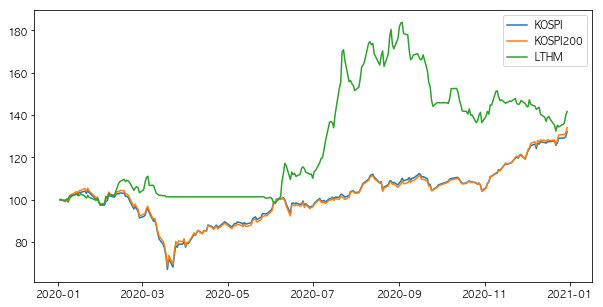

In [160]:
system.show_chart()

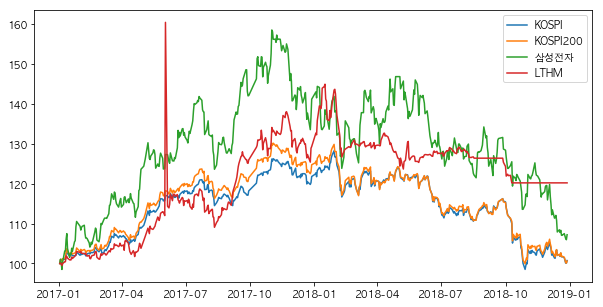

In [127]:
# 5atr stop loss, 15% preserve, 2 buy per day
system.show_chart()

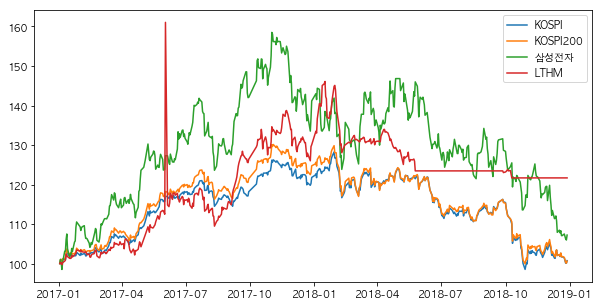

In [121]:
# 5atr stop loss, 15% preserve, 1 buy per day
system.show_chart()

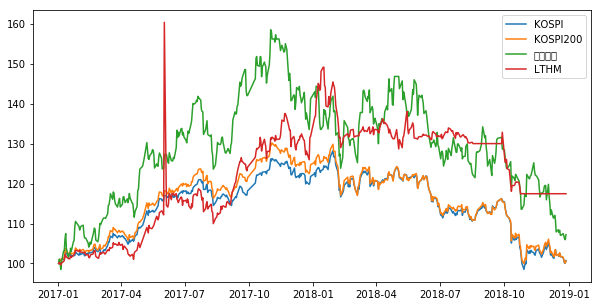

In [113]:
# 5atr stop loss, 15% preserve
system.show_chart()

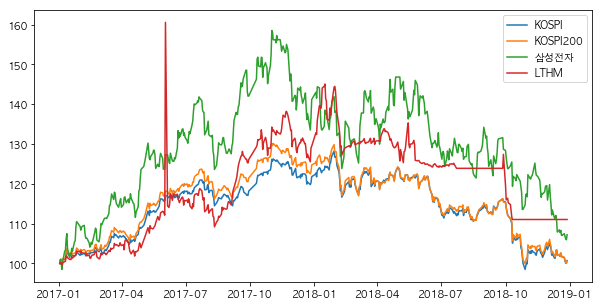

In [118]:
# 2atr stop loss, 15% perserve
system.show_chart()

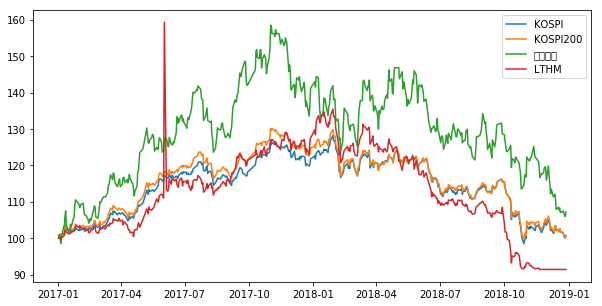

In [108]:
# 5atr stop loss, 25% preserve
system.show_chart()

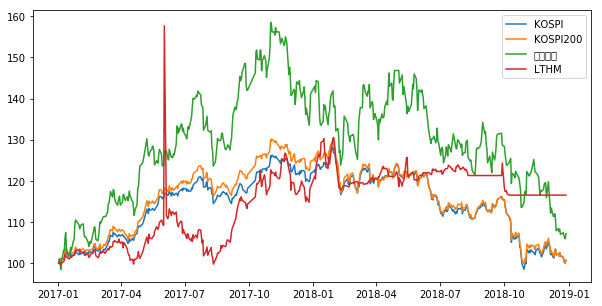

In [98]:
# 3% stop loss, 10% preserve
system.show_chart()

In [112]:
for year in range(2018,2019):
    load_std_dict(std_dict, year)
    load_ticker_dict(ticker_dict, year)
    system.backtest(year)

LTHM.get_buy_count(): buy_count=77 position_amount=13551632             total=135516322.4375 cash=34401606.4375 position_limit=13551632 cash_limit=33046443.213125
action: {'name': 'buy', 'idx': '2018-01-03', 'code': '035420.KS', 'stock_name': 'NAVER', 'count': 77, 'price': 174200.0, 'prev_rate180': 1.1614401858304297}
Asset.display(): total=135516322.4375 cash=20988206.4375 cash_percent=15.49
     code= 005490.KS stock_name= POSCO count= 38 price= 357500.0 amount= 13585000.0 highest_price= 357500.0 profit_percent= 37.24
     code= 051910.KS stock_name= LG화학 count= 38 price= 409500.0 amount= 15561000.0 highest_price= 423500.0 profit_percent= 51.95
     code= 009150.KS stock_name= 삼성전기 count= 103 price= 100000.0 amount= 10300000.0 highest_price= 112000.0 profit_percent= 0.7
     code= 068270.KS stock_name= 셀트리온 count= 104 price= 225829.0 amount= 23486216.0 highest_price= 225829.0 profit_percent= 132.13
     code= 066570.KS stock_name= LG전자 count= 137 price= 109500.0 amount= 15001500.0 hi

LTHM.get_buy_count(): buy_count=178 position_amount=5980800.0             total=139418514.4375 cash=41067114.4375 position_limit=13941851 cash_limit=39672929.293125
action: {'name': 'buy', 'idx': '2018-01-22', 'code': '009420.KS', 'stock_name': '한올바이오파마', 'count': 178, 'price': 33600.0, 'prev_rate180': 177.68595041322314}
Asset.display(): total=139418514.4375 cash=35086314.4375 cash_percent=25.17
     code= 005490.KS stock_name= POSCO count= 38 price= 385500.0 amount= 14649000.0 highest_price= 386500.0 profit_percent= 47.98
     code= 051910.KS stock_name= LG화학 count= 38 price= 423500.0 amount= 16093000.0 highest_price= 437000.0 profit_percent= 57.14
     code= 009150.KS stock_name= 삼성전기 count= 103 price= 101500.0 amount= 10454500.0 highest_price= 112000.0 profit_percent= 2.22
     code= 066570.KS stock_name= LG전자 count= 137 price= 107500.0 amount= 14727500.0 highest_price= 111000.0 profit_percent= 26.03
     code= 035420.KS stock_name= NAVER count= 77 price= 176200.0 amount= 13567400.

LTHM.get_buy_count(): buy_count=340 position_amount=4607000.0             total=131175063.4375 cash=106058063.4375 position_limit=13117506 cash_limit=104746312.803125
action: {'name': 'buy', 'idx': '2018-04-27', 'code': '006490.KS', 'stock_name': '인스코비', 'count': 340, 'price': 13550.0, 'prev_rate180': 642.4657534246576}
Asset.display(): total=131175063.4375 cash=101451063.4375 cash_percent=77.34
     code= 066570.KS stock_name= LG전자 count= 137 price= 101000.0 amount= 13837000.0 highest_price= 113500.0 profit_percent= 18.41
     code= 018260.KS stock_name= 삼성에스디에스 count= 47 price= 240000.0 amount= 11280000.0 highest_price= 260000.0 profit_percent= -7.16
     code= 006490.KS stock_name= 인스코비 count= 340 price= 13550.0 amount= 4607000.0 highest_price= 13550.0 profit_percent= 0.0
LTHM.get_buy_count(): buy_count=147 position_amount=2844450.0             total=131175063.4375 cash=101451063.4375 position_limit=13117506 cash_limit=100139312.803125
action: {'name': 'buy', 'idx': '2018-04-27', 'c

LTHM.is_profit_reserve(): code= 207940.KS stock_name= 삼성바이오로직스 buy_price= 506000.0 price= 404000.0 highest_price= 506000.0
action: {'name': 'sell', 'idx': '2018-05-02', 'code': '207940.KS', 'stock_name': '삼성바이오로직스', 'count': 22, 'price': 404000.0, 'buy_price': 506000.0, 'profit_percent': -20.16}
Asset.display(): total=131355652.203125 cash=45450713.4375 cash_percent=34.6
     code= 066570.KS stock_name= LG전자 count= 137 price= 102000.0 amount= 13974000.0 highest_price= 113500.0 profit_percent= 19.58
     code= 018260.KS stock_name= 삼성에스디에스 count= 47 price= 245000.0 amount= 11515000.0 highest_price= 260000.0 profit_percent= -5.22
     code= 006490.KS stock_name= 인스코비 count= 340 price= 12700.0 amount= 4318000.0 highest_price= 13550.0 profit_percent= -6.27
     code= 033180.KS stock_name= KH 필룩스 count= 147 price= 17100.0 amount= 2513700.0 highest_price= 19350.0 profit_percent= -11.63
     code= 005690.KS stock_name= 파미셀 count= 210 price= 17750.0 amount= 3727500.0 highest_price= 18700.0 pro

LTHM.is_profit_reserve(): code= 000660.KS stock_name= SK하이닉스 buy_price= 87100.0 price= 80500.0 highest_price= 95300.0
action: {'name': 'sell', 'idx': '2018-07-25', 'code': '000660.KS', 'stock_name': 'SK하이닉스', 'count': 150, 'price': 80500.0, 'buy_price': 87100.0, 'profit_percent': -7.58}
Asset.display(): total=132251675.25390625 cash=115292175.25390625 cash_percent=87.18
     code= 009150.KS stock_name= 삼성전기 count= 107 price= 158500.0 amount= 16959500.0 highest_price= 162500.0 profit_percent= 30.45
LTHM.is_profit_reserve(): code= 009150.KS stock_name= 삼성전기 buy_price= 121500.0 price= 137500.0 highest_price= 163000.0
action: {'name': 'sell', 'idx': '2018-08-17', 'code': '009150.KS', 'stock_name': '삼성전기', 'count': 107, 'price': 137500.0, 'buy_price': 121500.0, 'profit_percent': 13.17}
Asset.display(): total=130004675.25390625 cash=130004675.25390625 cash_percent=100.0
LTHM.get_buy_count(): buy_count=393 position_amount=12418800.0             total=130004675.25390625 cash=130004675.25390625

LTHM.is_profit_reserve(): code= 017800.KS stock_name= 현대엘리베이 buy_price= 77000.0 price= 75333.296875 highest_price= 111500.0
action: {'name': 'sell', 'idx': '2018-10-01', 'code': '017800.KS', 'stock_name': '현대엘리베이', 'count': 127, 'price': 75333.296875, 'buy_price': 77000.0, 'profit_percent': -2.16}
Asset.display(): total=127981603.95703125 cash=54648053.95703125 cash_percent=42.7
     code= 064350.KS stock_name= 현대로템 count= 393 price= 30900.0 amount= 12143700.0 highest_price= 31600.0 profit_percent= -2.22
     code= 002210.KS stock_name= 동성제약 count= 135 price= 31750.0 amount= 4286250.0 highest_price= 37200.0 profit_percent= -14.65
     code= 000720.KS stock_name= 현대건설 count= 192 price= 67800.0 amount= 13017600.0 highest_price= 67800.0 profit_percent= 0.59
     code= 009150.KS stock_name= 삼성전기 count= 85 price= 139000.0 amount= 11815000.0 highest_price= 142000.0 profit_percent= -2.11
     code= 006400.KS stock_name= 삼성SDI count= 49 price= 258500.0 amount= 12666500.0 highest_price= 261000.

In [92]:
asset=system.asset
system_data=system.data

In [94]:
system = LTHM(max_percent=10)
system.set_asset(asset)
system.set_data(system_data)

## 시스템 - max_percent=33

In [ ]:
stock_store = StockStore(ticker_dict)
system = LTHM(max_percent=33)
system.backtest()
#system.apply('2020-01-02')
#system.apply('2020-01-03')
#system.action_histories

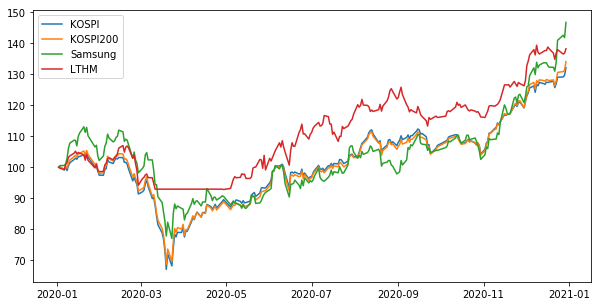

In [31]:
system.show_chart()

In [166]:
class DM(LTHM):
    def __init__(self, stock_store, max_percent=100, cash=100000000):
        self.REBALANCE_DAY = 1
        self.rebalance_date = pd.Timestamp(1970, 1, 1, 9)
        self.add_percent = [0, 0, 0, 0]
        super().__init__(stock_store, max_percent=max_percent, cash=cash)
        
    def filter_batch_data(self, batch_data):  
        if (len(batch_data) == 0):
            return batch_data
        
        # 종목 거래 금액, 주가, 이동 평균 filter
        filtered_data = batch_data[\
            (batch_data['ata20'] > self.MIN_TRADING_AMOUNT) &\
            (batch_data['Close'] > self.MIN_STOCK_PRICE) &\
            (batch_data['ma25'] > batch_data['ma50']) &\
            (batch_data['prev_rate180'] >= 0)]
        return filtered_data
    
    def prioritize_batch_data(self, batch_data):
        return batch_data.sort_values(by='prev_rate180', ascending=False)

    def backtest(self, year):
        start_idx = f"{year}-01-01"
        end_idx = f"{year}-12-31"
        ticker_data = stock_store.std_dict[stock_store.STD_STOCK_CODE]['data']
        ticker_data = ticker_data[start_idx:end_idx]
        for idx, row in ticker_data.iterrows():
            #log.debug("LTHM.backtest(): idx=%s", idx)
            self.apply(idx)

        add_relative_value(self.data, 'total') # total 값을 이용하여 relative_value 컬럼 추가
        return
    
    def apply(self, idx):
        # 가격 반영
        for k in list(self.asset.stocks.keys()):
            code = k
            ticker_data = stock_store.ticker_dict[code]['data']
            if (idx in ticker_data.index):
                row = ticker_data.loc[idx]
                price = row['Close']
                self.asset.apply(code, price) 
            else:
                log.debug("DM.apply(): ticker_data index not found, ignored: idx=%s code=%s", idx, code)
                
        # 매수/재매수 체크 & 진입
        if (self.asset.get_stock_count() == 0):
            self.apply_initial_buy(idx)
            
        # Rebalance
        if (idx.month != self.rebalance_date.month and idx.day >= self.REBALANCE_DAY):
            self.apply_rebalance(idx)
        
        self.data = self.data.append(pd.Series({'total':self.asset.total, 'cash':self.asset.cash}, index=self.data.columns, name=idx))    
        return
    
    def apply_initial_buy(self, idx):
        batch_data = self.make_batch_data(idx)
        if (len(batch_data) < len(stock_store.ticker_dict)):
            log.warning("apply_initial_buy(): batch_data missing, skipping - idx=%s batch_data len=%d", idx, len(batch_data))
            return
        batch_data = self.prioritize_batch_data(batch_data)
        
        # 첫번째 선택
        highest_row = batch_data.iloc[0]
        highest_code = highest_row['code']
        self.buy_position(idx, highest_code, highest_row, False)
        #if (highest_row['prev_rate180'] > 0):
        #    self.buy_position(idx, highest_code, highest_row, False)
        #log.debug("apply(): 1st=%.2f 2nd=%.2f 3rd=%.2f", \
        #          batch_data.iloc[0]['prev_rate180'], batch_data.iloc[1]['prev_rate180'], batch_data.iloc[2]['prev_rate180'])

        self.initial_buy = True
        self.rebalance_date = idx
                
    def apply_rebalance(self, idx):
        batch_data = self.make_batch_data(idx)
        if (len(batch_data) < len(stock_store.ticker_dict)):
            log.warning("apply_initial_buy(): batch_data missing, skipping - idx=%s batch_data len=%d", idx, len(batch_data))
            return
        batch_data = self.prioritize_batch_data(batch_data)
        
        # 첫번째 선택
        highest_row = batch_data.iloc[0]
        highest_code = highest_row['code']
        log.debug("DM.apply_rebalance(): idx=%s code=%s prev_rate180=%.2f", idx, highest_code, highest_row['prev_rate180'])
        
        # 추가 percent 적용
        self.apply_add_percent(idx, highest_code, highest_row)
        
        #if (highest_row['prev_rate180'] <= 0):
        #    log.debug("apply_rebalance(): ### sell_all idx=%s", idx)
        #    self.sell_all(idx)
        if (not self.asset.is_stock(highest_code)):
            self.apply_rebalance_stock_change(idx, highest_code, highest_row)
        else:
            self.apply_rebalance_stock_share(idx, highest_code, highest_row)
            
        log.debug("DM.apply_rebalance(): stock_percent=%.2f", (self.asset.total-self.asset.cash)/self.asset.total*100)
        self.rebalance_date = idx
    
    def apply_add_percent(self, idx, highest_code, highest_row):
        return
    
    def apply_add_percent_old(self, idx, highest_code, highest_row):
        code = highest_code
        row = highest_row
        rate = row['prev_rate180']
        if (rate <= -10 and rate > -20):
            self.add_percent[1] = 10
        elif (rate <= -20 and rate > -30):
            self.add_percent[1] = 10
            self.add_percent[2] = 10
        elif (rate <= -30):
            self.add_percent[1] = 10
            self.add_percent[2] = 10
            self.add_percent[3] = 10
        if (rate >= 10 and rate < 20):
            self.add_percent[3] = 0
        elif (rate >= 20 and rate < 30):
            self.add_percent[2] = 0
            self.add_percent[3] = 0
        elif (rate >= 30):
            self.add_percent[1] = 0
            self.add_percent[2] = 0
            self.add_percent[3] = 0
    
    def get_total_percent(self):
        total_percent = self.MAX_POSITION_PERCENT
        for p in self.add_percent:
            total_percent += p
        return total_percent            
        
    def apply_rebalance_stock_change(self, idx, highest_code, highest_row):
        code = highest_code
        row = highest_row
        price = row['Close']
        atr20 = row['atr20']
        
        # 기존 종목 전체 매도
        self.sell_all(idx)

        # 신규 매수
        stock_amount = self.asset.total - self.asset.cash
        max_amount = self.asset.total * self.get_total_percent() / 100
        buy_cash = max_amount - stock_amount
        buy_count = math.floor(buy_cash / price)
        self.buy_count(idx, code, row, buy_count)           
        #self.buy_position(idx, highest_code, highest_row, False)
            
    def apply_rebalance_stock_share(self, idx, highest_code, highest_row):
        code = highest_code
        row = highest_row
        price = row['Close']
        atr20 = row['atr20']
        
        stock_amount = self.asset.total - self.asset.cash
        max_amount = self.asset.total * self.get_total_percent() / 100
        if (stock_amount > max_amount):
            sell_cash = stock_amount - max_amount
            sell_count = math.ceil(sell_cash / price)
            self.sell_count(idx, code, row, sell_count)
        else:
            buy_cash = max_amount - stock_amount
            buy_count = math.floor(buy_cash / price)
            self.buy_count(idx, code, row, buy_count)   
            
    def sell_all(self, idx):
        for k in list(self.asset.stocks.keys()):
            code = k
            ticker_data = stock_store.ticker_dict[code]['data']
            if (idx in ticker_data.index):
                row = ticker_data.loc[idx]
                #self.apply_stock_sell(idx, code, row)
                self.sell_position(idx, code, row)


In [167]:
stock_store = StockStore(ticker_dict_3)
system = DM(stock_store, max_percent=90)

for year in range(2000,2011):
    stock_store.load_std_dict(year)
    stock_store.load_ticker_dict(year)
    system.backtest(year)

2021-10-04 11:21:03,386 - DEBUG - StockStore.pad_ticker_data(): code=KS200 stock_name=KOSPI200 ticker_data len=1 std_data len=241 start_time=2000-01-01 09:00:00
2021-10-04 11:21:03,916 - DEBUG - StockStore.pad_ticker_data(): code=KS200 stock_name=KOSPI200 ticker_data len=1 std_data len=241 start_time=2000-01-01 09:00:00
2021-10-04 11:21:04,404 - DEBUG - StockStore.pad_ticker_data(): code=SPY stock_name=SPY ticker_data len=252 std_data len=241 start_time=2000-01-01 09:00:00
2021-10-04 11:21:04,449 - DEBUG - StockStore.pad_ticker_data(): code=QQQ stock_name=QQQ ticker_data len=252 std_data len=241 start_time=2000-01-01 09:00:00
2021-10-04 11:21:04,570 - WARNING - apply_initial_buy(): batch_data missing, skipping - idx=2000-01-04 00:00:00 batch_data len=2
2021-10-04 11:21:04,592 - WARNING - apply_initial_buy(): batch_data missing, skipping - idx=2000-01-05 00:00:00 batch_data len=2
2021-10-04 11:21:04,620 - WARNING - apply_initial_buy(): batch_data missing, skipping - idx=2000-01-06 00:00

2021-10-04 11:21:05,530 - WARNING - apply_initial_buy(): batch_data missing, skipping - idx=2000-02-29 00:00:00 batch_data len=2
2021-10-04 11:21:05,546 - WARNING - apply_initial_buy(): batch_data missing, skipping - idx=2000-03-02 00:00:00 batch_data len=2
2021-10-04 11:21:05,560 - WARNING - apply_initial_buy(): batch_data missing, skipping - idx=2000-03-02 00:00:00 batch_data len=2
2021-10-04 11:21:05,577 - WARNING - apply_initial_buy(): batch_data missing, skipping - idx=2000-03-03 00:00:00 batch_data len=2
2021-10-04 11:21:05,592 - WARNING - apply_initial_buy(): batch_data missing, skipping - idx=2000-03-03 00:00:00 batch_data len=2
2021-10-04 11:21:05,610 - WARNING - apply_initial_buy(): batch_data missing, skipping - idx=2000-03-06 00:00:00 batch_data len=2
2021-10-04 11:21:05,626 - WARNING - apply_initial_buy(): batch_data missing, skipping - idx=2000-03-06 00:00:00 batch_data len=2
2021-10-04 11:21:05,643 - WARNING - apply_initial_buy(): batch_data missing, skipping - idx=2000-

2021-10-04 11:21:07,494 - WARNING - apply_initial_buy(): batch_data missing, skipping - idx=2000-06-07 00:00:00 batch_data len=2
2021-10-04 11:21:07,510 - WARNING - apply_initial_buy(): batch_data missing, skipping - idx=2000-06-07 00:00:00 batch_data len=2
2021-10-04 11:21:07,526 - WARNING - apply_initial_buy(): batch_data missing, skipping - idx=2000-06-08 00:00:00 batch_data len=2
2021-10-04 11:21:07,541 - WARNING - apply_initial_buy(): batch_data missing, skipping - idx=2000-06-08 00:00:00 batch_data len=2
2021-10-04 11:21:07,558 - WARNING - apply_initial_buy(): batch_data missing, skipping - idx=2000-06-09 00:00:00 batch_data len=2
2021-10-04 11:21:07,572 - WARNING - apply_initial_buy(): batch_data missing, skipping - idx=2000-06-09 00:00:00 batch_data len=2
2021-10-04 11:21:07,589 - WARNING - apply_initial_buy(): batch_data missing, skipping - idx=2000-06-12 00:00:00 batch_data len=2
2021-10-04 11:21:07,604 - WARNING - apply_initial_buy(): batch_data missing, skipping - idx=2000-

2021-10-04 11:21:09,464 - WARNING - apply_initial_buy(): batch_data missing, skipping - idx=2000-09-06 00:00:00 batch_data len=2
2021-10-04 11:21:09,480 - WARNING - apply_initial_buy(): batch_data missing, skipping - idx=2000-09-07 00:00:00 batch_data len=2
2021-10-04 11:21:09,495 - WARNING - apply_initial_buy(): batch_data missing, skipping - idx=2000-09-07 00:00:00 batch_data len=2
2021-10-04 11:21:09,512 - WARNING - apply_initial_buy(): batch_data missing, skipping - idx=2000-09-08 00:00:00 batch_data len=2
2021-10-04 11:21:09,526 - WARNING - apply_initial_buy(): batch_data missing, skipping - idx=2000-09-08 00:00:00 batch_data len=2
2021-10-04 11:21:09,544 - WARNING - apply_initial_buy(): batch_data missing, skipping - idx=2000-09-14 00:00:00 batch_data len=2
2021-10-04 11:21:09,558 - WARNING - apply_initial_buy(): batch_data missing, skipping - idx=2000-09-14 00:00:00 batch_data len=2
2021-10-04 11:21:09,575 - WARNING - apply_initial_buy(): batch_data missing, skipping - idx=2000-

2021-10-04 11:21:10,517 - WARNING - apply_initial_buy(): batch_data missing, skipping - idx=2000-10-26 00:00:00 batch_data len=2
2021-10-04 11:21:10,533 - WARNING - apply_initial_buy(): batch_data missing, skipping - idx=2000-10-27 00:00:00 batch_data len=2
2021-10-04 11:21:10,548 - WARNING - apply_initial_buy(): batch_data missing, skipping - idx=2000-10-27 00:00:00 batch_data len=2
2021-10-04 11:21:10,565 - WARNING - apply_initial_buy(): batch_data missing, skipping - idx=2000-10-30 00:00:00 batch_data len=2
2021-10-04 11:21:10,580 - WARNING - apply_initial_buy(): batch_data missing, skipping - idx=2000-10-30 00:00:00 batch_data len=2
2021-10-04 11:21:10,597 - WARNING - apply_initial_buy(): batch_data missing, skipping - idx=2000-10-31 00:00:00 batch_data len=2
2021-10-04 11:21:10,612 - WARNING - apply_initial_buy(): batch_data missing, skipping - idx=2000-10-31 00:00:00 batch_data len=2
2021-10-04 11:21:10,628 - WARNING - apply_initial_buy(): batch_data missing, skipping - idx=2000-

2021-10-04 11:21:11,503 - WARNING - apply_initial_buy(): batch_data missing, skipping - idx=2000-12-11 00:00:00 batch_data len=2
2021-10-04 11:21:11,520 - WARNING - apply_initial_buy(): batch_data missing, skipping - idx=2000-12-12 00:00:00 batch_data len=2
2021-10-04 11:21:11,535 - WARNING - apply_initial_buy(): batch_data missing, skipping - idx=2000-12-12 00:00:00 batch_data len=2
2021-10-04 11:21:11,552 - WARNING - apply_initial_buy(): batch_data missing, skipping - idx=2000-12-13 00:00:00 batch_data len=2
2021-10-04 11:21:11,567 - WARNING - apply_initial_buy(): batch_data missing, skipping - idx=2000-12-13 00:00:00 batch_data len=2
2021-10-04 11:21:11,584 - WARNING - apply_initial_buy(): batch_data missing, skipping - idx=2000-12-14 00:00:00 batch_data len=2
2021-10-04 11:21:11,599 - WARNING - apply_initial_buy(): batch_data missing, skipping - idx=2000-12-14 00:00:00 batch_data len=2
2021-10-04 11:21:11,615 - WARNING - apply_initial_buy(): batch_data missing, skipping - idx=2000-

2021-10-04 11:21:12,992 - INFO - action={'name': 'buy', 'idx': '2001-07-02', 'code': 'KS200', 'stock_name': 'KOSPI200', 'count': 1267719, 'price': 73.4, 'prev_rate180': 4.65}
2021-10-04 11:21:12,993 - INFO - Asset.display(): total=103389542 cash=10338968 cash_percent=10.00
2021-10-04 11:21:12,993 - INFO -      code=KS200 stock_name=KOSPI200 count=1267719 price=73.40 amount=93050574 highest_price=73.40 profit_percent=0.00
2021-10-04 11:21:12,994 - DEBUG - DM.apply_rebalance(): stock_percent=90.00
2021-10-04 11:21:13,068 - DEBUG - DM.apply_rebalance(): idx=2001-08-01 00:00:00 code=KS200 prev_rate180=-3.75
2021-10-04 11:21:13,069 - INFO - action={'name': 'buy', 'idx': '2001-08-01', 'code': 'KS200', 'stock_name': 'KOSPI200', 'count': 6691, 'price': 69.72, 'prev_rate180': -3.75}
2021-10-04 11:21:13,070 - INFO - Asset.display(): total=98724336 cash=9872471 cash_percent=10.00
2021-10-04 11:21:13,071 - INFO -      code=KS200 stock_name=KOSPI200 count=1274410 price=69.72 amount=88851865 highest

2021-10-04 11:21:14,210 - DEBUG - DM.apply_rebalance(): stock_percent=90.00
2021-10-04 11:21:14,289 - DEBUG - DM.apply_rebalance(): idx=2002-08-01 00:00:00 code=KS200 prev_rate180=-7.99
2021-10-04 11:21:14,290 - INFO - action={'name': 'buy', 'idx': '2002-08-01', 'code': 'KS200', 'stock_name': 'KOSPI200', 'count': 7430, 'price': 88.77, 'prev_rate180': -7.99}
2021-10-04 11:21:14,291 - INFO - Asset.display(): total=123241913 cash=12324242 cash_percent=10.00
2021-10-04 11:21:14,292 - INFO -      code=KS200 stock_name=KOSPI200 count=1249495 price=88.77 amount=110917671 highest_price=117.66 profit_percent=0.00
2021-10-04 11:21:14,292 - DEBUG - DM.apply_rebalance(): stock_percent=90.00
2021-10-04 11:21:14,355 - WARNING - apply_initial_buy(): batch_data missing, skipping - idx=2002-09-02 00:00:00 batch_data len=1
2021-10-04 11:21:14,378 - DEBUG - DM.apply_rebalance(): idx=2002-09-03 00:00:00 code=KS200 prev_rate180=-11.90
2021-10-04 11:21:14,379 - INFO - action={'name': 'sell', 'idx': '2002-09

2021-10-04 11:21:15,325 - INFO -      code=QQQ stock_name=QQQ count=4017588 price=29.46 amount=118358142 highest_price=29.67 profit_percent=20.79
2021-10-04 11:21:15,325 - DEBUG - DM.apply_rebalance(): stock_percent=90.00
2021-10-04 11:21:15,401 - DEBUG - DM.apply_rebalance(): idx=2003-07-01 00:00:00 code=QQQ prev_rate180=23.20
2021-10-04 11:21:15,402 - INFO - action={'name': 'sell', 'idx': '2003-07-01', 'code': 'QQQ', 'stock_name': 'QQQ', 'count': 10104, 'price': 30.22, 'buy_price': 24.39, 'profit_percent': 23.9}
2021-10-04 11:21:15,402 - INFO - Asset.display(): total=134562436 cash=13456270 cash_percent=10.00
2021-10-04 11:21:15,403 - INFO -      code=QQQ stock_name=QQQ count=4007484 price=30.22 amount=121106166 highest_price=30.79 profit_percent=23.90
2021-10-04 11:21:15,403 - DEBUG - DM.apply_rebalance(): stock_percent=90.00
2021-10-04 11:21:15,412 - DEBUG - DM.apply(): ticker_data index not found, ignored: idx=2003-07-04 00:00:00 code=QQQ
2021-10-04 11:21:15,485 - DEBUG - DM.apply

2021-10-04 11:21:16,541 - INFO - Asset.display(): total=158571594 cash=158571594 cash_percent=100.00
2021-10-04 11:21:16,542 - INFO - action={'name': 'buy', 'idx': '2004-06-01', 'code': 'SPY', 'stock_name': 'SPY', 'count': 1266209, 'price': 112.71, 'prev_rate180': 6.34}
2021-10-04 11:21:16,542 - INFO - Asset.display(): total=158571594 cash=15857177 cash_percent=10.00
2021-10-04 11:21:16,543 - INFO -      code=SPY stock_name=SPY count=1266209 price=112.71 amount=142714416 highest_price=112.71 profit_percent=0.00
2021-10-04 11:21:16,544 - DEBUG - DM.apply_rebalance(): stock_percent=90.00
2021-10-04 11:21:16,566 - DEBUG - DM.apply(): ticker_data index not found, ignored: idx=2004-06-11 00:00:00 code=SPY
2021-10-04 11:21:16,626 - DEBUG - DM.apply_rebalance(): idx=2004-07-01 00:00:00 code=QQQ prev_rate180=3.19
2021-10-04 11:21:16,627 - INFO - action={'name': 'sell', 'idx': '2004-07-01', 'code': 'SPY', 'stock_name': 'SPY', 'count': 1266209, 'price': 112.94, 'buy_price': 112.71, 'profit_perce

2021-10-04 11:21:17,626 - DEBUG - DM.apply_rebalance(): idx=2005-04-01 00:00:00 code=KS200 prev_rate180=15.96
2021-10-04 11:21:17,627 - INFO - action={'name': 'buy', 'idx': '2005-04-01', 'code': 'KS200', 'stock_name': 'KOSPI200', 'count': 3309, 'price': 126.88, 'prev_rate180': 15.96}
2021-10-04 11:21:17,628 - INFO - Asset.display(): total=182061185 cash=18206196 cash_percent=10.00
2021-10-04 11:21:17,628 - INFO -      code=KS200 stock_name=KOSPI200 count=1291417 price=126.88 amount=163854988 highest_price=131.97 profit_percent=0.00
2021-10-04 11:21:17,629 - DEBUG - DM.apply_rebalance(): stock_percent=90.00
2021-10-04 11:21:17,699 - DEBUG - DM.apply_rebalance(): idx=2005-05-02 00:00:00 code=KS200 prev_rate180=9.70
2021-10-04 11:21:17,700 - INFO - action={'name': 'buy', 'idx': '2005-05-02', 'code': 'KS200', 'stock_name': 'KOSPI200', 'count': 9179, 'price': 118.46, 'prev_rate180': 9.7}
2021-10-04 11:21:17,700 - INFO - Asset.display(): total=171187454 cash=17118852 cash_percent=10.00
2021-

2021-10-04 11:21:18,858 - INFO - Asset.display(): total=248536596 cash=24853792 cash_percent=10.00
2021-10-04 11:21:18,859 - INFO -      code=KS200 stock_name=KOSPI200 count=1250393 price=178.89 amount=223682803 highest_price=182.39 profit_percent=1.15
2021-10-04 11:21:18,859 - DEBUG - DM.apply_rebalance(): stock_percent=90.00
2021-10-04 11:21:18,936 - DEBUG - DM.apply_rebalance(): idx=2006-05-02 00:00:00 code=KS200 prev_rate180=19.65
2021-10-04 11:21:18,937 - INFO - action={'name': 'sell', 'idx': '2006-05-02', 'code': 'KS200', 'stock_name': 'KOSPI200', 'count': 4889, 'price': 186.17, 'buy_price': 176.85, 'profit_percent': 5.27}
2021-10-04 11:21:18,938 - INFO - Asset.display(): total=257639457 cash=25763977 cash_percent=10.00
2021-10-04 11:21:18,939 - INFO -      code=KS200 stock_name=KOSPI200 count=1245504 price=186.17 amount=231875479 highest_price=188.40 profit_percent=5.27
2021-10-04 11:21:18,940 - DEBUG - DM.apply_rebalance(): stock_percent=90.00
2021-10-04 11:21:19,018 - DEBUG - 

2021-10-04 11:21:20,009 - INFO - Asset.display(): total=247685584 cash=24768560 cash_percent=10.00
2021-10-04 11:21:20,009 - INFO -      code=QQQ stock_name=QQQ count=5269906 price=42.30 amount=222917023 highest_price=45.23 profit_percent=0.00
2021-10-04 11:21:20,010 - DEBUG - DM.apply_rebalance(): stock_percent=90.00
2021-10-04 11:21:20,089 - DEBUG - DM.apply_rebalance(): idx=2007-04-02 00:00:00 code=QQQ prev_rate180=6.76
2021-10-04 11:21:20,090 - INFO - action={'name': 'sell', 'idx': '2007-04-02', 'code': 'QQQ', 'stock_name': 'QQQ', 'count': 13476, 'price': 43.41, 'buy_price': 42.3, 'profit_percent': 2.62}
2021-10-04 11:21:20,090 - INFO - Asset.display(): total=253535179 cash=25353553 cash_percent=10.00
2021-10-04 11:21:20,091 - INFO -      code=QQQ stock_name=QQQ count=5256430 price=43.41 amount=228181626 highest_price=45.23 profit_percent=2.62
2021-10-04 11:21:20,092 - DEBUG - DM.apply_rebalance(): stock_percent=90.00
2021-10-04 11:21:20,103 - DEBUG - DM.apply(): ticker_data index 

2021-10-04 11:21:21,187 - DEBUG - DM.apply_rebalance(): stock_percent=90.00
2021-10-04 11:21:21,209 - DEBUG - DM.apply(): ticker_data index not found, ignored: idx=2008-02-18 00:00:00 code=QQQ
2021-10-04 11:21:21,258 - DEBUG - DM.apply_rebalance(): idx=2008-03-03 00:00:00 code=SPY prev_rate180=-7.11
2021-10-04 11:21:21,260 - INFO - action={'name': 'sell', 'idx': '2008-03-03', 'code': 'QQQ', 'stock_name': 'QQQ', 'count': 5549198, 'price': 42.49, 'buy_price': 45.4, 'profit_percent': -6.41}
2021-10-04 11:21:21,260 - INFO - Asset.display(): total=263778055 cash=263778055 cash_percent=100.00
2021-10-04 11:21:21,261 - INFO - action={'name': 'buy', 'idx': '2008-03-03', 'code': 'SPY', 'stock_name': 'SPY', 'count': 1778279, 'price': 133.5, 'prev_rate180': -7.11}
2021-10-04 11:21:21,261 - INFO - Asset.display(): total=263778055 cash=26377808 cash_percent=10.00
2021-10-04 11:21:21,262 - INFO -      code=SPY stock_name=SPY count=1778279 price=133.50 amount=237400246 highest_price=133.50 profit_per

2021-10-04 11:21:22,008 - INFO -      code=KS200 stock_name=KOSPI200 count=1017662 price=138.33 amount=140773184 highest_price=138.33 profit_percent=0.00
2021-10-04 11:21:22,009 - DEBUG - DM.apply_rebalance(): stock_percent=90.00
2021-10-04 11:21:22,239 - DEBUG - StockStore.pad_ticker_data(): code=SPY stock_name=SPY ticker_data len=252 std_data len=253 start_time=2009-01-01 09:00:00
2021-10-04 11:21:22,280 - DEBUG - StockStore.pad_ticker_data(): code=QQQ stock_name=QQQ ticker_data len=252 std_data len=253 start_time=2009-01-01 09:00:00
2021-10-04 11:21:22,334 - DEBUG - DM.apply_rebalance(): idx=2009-01-02 00:00:00 code=KS200 prev_rate180=-25.08
2021-10-04 11:21:22,335 - INFO - action={'name': 'sell', 'idx': '2009-01-02', 'code': 'KS200', 'stock_name': 'KOSPI200', 'count': 8631, 'price': 151.15, 'buy_price': 138.33, 'profit_percent': 9.27}
2021-10-04 11:21:22,336 - INFO - Asset.display(): total=169461223 cash=16946187 cash_percent=10.00
2021-10-04 11:21:22,336 - INFO -      code=KS200 s

2021-10-04 11:21:23,102 - DEBUG - DM.apply_rebalance(): stock_percent=90.00
2021-10-04 11:21:23,148 - DEBUG - DM.apply(): ticker_data index not found, ignored: idx=2009-11-26 00:00:00 code=QQQ
2021-10-04 11:21:23,177 - DEBUG - DM.apply_rebalance(): idx=2009-12-01 00:00:00 code=QQQ prev_rate180=21.14
2021-10-04 11:21:23,178 - INFO - action={'name': 'sell', 'idx': '2009-12-01', 'code': 'QQQ', 'stock_name': 'QQQ', 'count': 31421, 'price': 43.83, 'buy_price': 40.83, 'profit_percent': 7.35}
2021-10-04 11:21:23,179 - INFO - Asset.display(): total=232158482 cash=23215875 cash_percent=10.00
2021-10-04 11:21:23,180 - INFO -      code=QQQ stock_name=QQQ count=4767114 price=43.83 amount=208942606 highest_price=44.42 profit_percent=7.35
2021-10-04 11:21:23,181 - DEBUG - DM.apply_rebalance(): stock_percent=90.00
2021-10-04 11:21:23,419 - DEBUG - StockStore.pad_ticker_data(): code=SPY stock_name=SPY ticker_data len=252 std_data len=251 start_time=2010-01-01 09:00:00
2021-10-04 11:21:23,464 - DEBUG -

2021-10-04 11:21:24,270 - INFO - action={'name': 'sell', 'idx': '2010-10-01', 'code': 'KS200', 'stock_name': 'KOSPI200', 'count': 5312, 'price': 243.49, 'buy_price': 229.41, 'profit_percent': 6.14}
2021-10-04 11:21:24,270 - INFO - Asset.display(): total=247078721 cash=24708070 cash_percent=10.00
2021-10-04 11:21:24,271 - INFO -      code=KS200 stock_name=KOSPI200 count=913264 price=243.49 amount=222370651 highest_price=243.49 profit_percent=6.14
2021-10-04 11:21:24,272 - DEBUG - DM.apply_rebalance(): stock_percent=90.00
2021-10-04 11:21:24,341 - DEBUG - DM.apply_rebalance(): idx=2010-11-01 00:00:00 code=KS200 prev_rate180=9.42
2021-10-04 11:21:24,342 - INFO - action={'name': 'sell', 'idx': '2010-11-01', 'code': 'KS200', 'stock_name': 'KOSPI200', 'count': 1447, 'price': 247.41, 'buy_price': 229.41, 'profit_percent': 7.85}
2021-10-04 11:21:24,343 - INFO - Asset.display(): total=250658716 cash=25066072 cash_percent=10.00
2021-10-04 11:21:24,343 - INFO -      code=KS200 stock_name=KOSPI200

In [168]:
for year in range(2011,2022):
    stock_store.load_std_dict(year)
    stock_store.load_ticker_dict(year)
    system.backtest(year)

2021-10-04 11:21:24,733 - DEBUG - StockStore.pad_ticker_data(): code=SPY stock_name=SPY ticker_data len=252 std_data len=248 start_time=2011-01-01 09:00:00
2021-10-04 11:21:24,778 - DEBUG - StockStore.pad_ticker_data(): code=QQQ stock_name=QQQ ticker_data len=252 std_data len=248 start_time=2011-01-01 09:00:00
2021-10-04 11:21:24,845 - DEBUG - DM.apply_rebalance(): idx=2011-01-03 00:00:00 code=QQQ prev_rate180=29.84
2021-10-04 11:21:24,846 - INFO - action={'name': 'sell', 'idx': '2011-01-03', 'code': 'KS200', 'stock_name': 'KOSPI200', 'count': 909873, 'price': 273.81, 'buy_price': 229.41, 'profit_percent': 19.35}
2021-10-04 11:21:24,847 - INFO - Asset.display(): total=274689841 cash=274689841 cash_percent=100.00
2021-10-04 11:21:24,848 - INFO - action={'name': 'buy', 'idx': '2011-01-03', 'code': 'QQQ', 'stock_name': 'QQQ', 'count': 4469731, 'price': 55.3100013733, 'prev_rate180': 29.84}
2021-10-04 11:21:24,848 - INFO - Asset.display(): total=274689841 cash=27469013 cash_percent=10.00
2

2021-10-04 11:21:25,594 - DEBUG - DM.apply_rebalance(): stock_percent=90.00
2021-10-04 11:21:25,670 - DEBUG - DM.apply_rebalance(): idx=2011-11-01 00:00:00 code=QQQ prev_rate180=-3.16
2021-10-04 11:21:25,671 - INFO - action={'name': 'sell', 'idx': '2011-11-01', 'code': 'QQQ', 'stock_name': 'QQQ', 'count': 31641, 'price': 56.4399986267, 'buy_price': 52.1899986267, 'profit_percent': 8.14}
2021-10-04 11:21:25,672 - INFO - Asset.display(): total=261516293 cash=26151678 cash_percent=10.00
2021-10-04 11:21:25,672 - INFO -      code=QQQ stock_name=QQQ count=4170174 price=56.44 amount=235364614 highest_price=58.94 profit_percent=8.14
2021-10-04 11:21:25,673 - DEBUG - DM.apply_rebalance(): stock_percent=90.00
2021-10-04 11:21:25,718 - DEBUG - DM.apply(): ticker_data index not found, ignored: idx=2011-11-24 00:00:00 code=QQQ
2021-10-04 11:21:25,756 - DEBUG - DM.apply_rebalance(): idx=2011-12-01 00:00:00 code=QQQ prev_rate180=1.59
2021-10-04 11:21:25,757 - INFO - action={'name': 'sell', 'idx': '2

2021-10-04 11:21:26,854 - INFO -      code=QQQ stock_name=QQQ count=4098040 price=68.09 amount=279035528 highest_price=68.43 profit_percent=12.71
2021-10-04 11:21:26,854 - DEBUG - DM.apply_rebalance(): stock_percent=90.00
2021-10-04 11:21:26,931 - DEBUG - DM.apply_rebalance(): idx=2012-10-02 00:00:00 code=SPY prev_rate180=3.32
2021-10-04 11:21:26,932 - INFO - action={'name': 'sell', 'idx': '2012-10-02', 'code': 'QQQ', 'stock_name': 'QQQ', 'count': 4098040, 'price': 68.6699981689, 'buy_price': 60.4099998474, 'profit_percent': 13.67}
2021-10-04 11:21:26,933 - INFO - Asset.display(): total=312416347 cash=312416347 cash_percent=100.00
2021-10-04 11:21:26,933 - INFO - action={'name': 'buy', 'idx': '2012-10-02', 'code': 'SPY', 'stock_name': 'SPY', 'count': 1945845, 'price': 144.5, 'prev_rate180': 3.32}
2021-10-04 11:21:26,934 - INFO - Asset.display(): total=312416347 cash=31241744 cash_percent=10.00
2021-10-04 11:21:26,935 - INFO -      code=SPY stock_name=SPY count=1945845 price=144.50 amou

2021-10-04 11:21:28,018 - DEBUG - DM.apply_rebalance(): idx=2013-07-01 00:00:00 code=SPY prev_rate180=10.48
2021-10-04 11:21:28,019 - INFO - action={'name': 'buy', 'idx': '2013-07-01', 'code': 'SPY', 'stock_name': 'SPY', 'count': 3317, 'price': 161.3600006104, 'prev_rate180': 10.48}
2021-10-04 11:21:28,020 - INFO - Asset.display(): total=321554925 cash=32155603 cash_percent=10.00
2021-10-04 11:21:28,020 - INFO -      code=SPY stock_name=SPY count=1793501 price=161.36 amount=289399322 highest_price=167.17 profit_percent=0.00
2021-10-04 11:21:28,021 - DEBUG - DM.apply_rebalance(): stock_percent=90.00
2021-10-04 11:21:28,030 - DEBUG - DM.apply(): ticker_data index not found, ignored: idx=2013-07-04 00:00:00 code=SPY
2021-10-04 11:21:28,109 - DEBUG - DM.apply_rebalance(): idx=2013-08-01 00:00:00 code=QQQ prev_rate180=15.13
2021-10-04 11:21:28,110 - INFO - action={'name': 'sell', 'idx': '2013-08-01', 'code': 'SPY', 'stock_name': 'SPY', 'count': 1793501, 'price': 170.6600036621, 'buy_price':

2021-10-04 11:21:30,198 - DEBUG - DM.apply_rebalance(): stock_percent=90.00
2021-10-04 11:21:30,277 - DEBUG - DM.apply_rebalance(): idx=2015-02-02 00:00:00 code=QQQ prev_rate180=7.32
2021-10-04 11:21:30,279 - INFO - action={'name': 'sell', 'idx': '2015-02-02', 'code': 'KS200', 'stock_name': 'KOSPI200', 'count': 1499108, 'price': 250.61, 'buy_price': 244.79, 'profit_percent': 2.38}
2021-10-04 11:21:30,279 - INFO - Asset.display(): total=416465645 cash=416465645 cash_percent=100.00
2021-10-04 11:21:30,280 - INFO - action={'name': 'buy', 'idx': '2015-02-02', 'code': 'QQQ', 'stock_name': 'QQQ', 'count': 3675417, 'price': 101.9800033569, 'prev_rate180': 7.32}
2021-10-04 11:21:30,281 - INFO - Asset.display(): total=416465645 cash=41646607 cash_percent=10.00
2021-10-04 11:21:30,282 - INFO -      code=QQQ stock_name=QQQ count=3675417 price=101.98 amount=374819037 highest_price=101.98 profit_percent=0.00
2021-10-04 11:21:30,282 - DEBUG - DM.apply_rebalance(): stock_percent=90.00
2021-10-04 11:2

2021-10-04 11:21:31,086 - DEBUG - DM.apply_rebalance(): stock_percent=90.00
2021-10-04 11:21:31,341 - DEBUG - StockStore.pad_ticker_data(): code=SPY stock_name=SPY ticker_data len=252 std_data len=246 start_time=2016-01-01 09:00:00
2021-10-04 11:21:31,391 - DEBUG - StockStore.pad_ticker_data(): code=QQQ stock_name=QQQ ticker_data len=253 std_data len=246 start_time=2016-01-01 09:00:00
2021-10-04 11:21:31,433 - DEBUG - DM.apply_rebalance(): idx=2016-01-04 00:00:00 code=QQQ prev_rate180=0.17
2021-10-04 11:21:31,434 - INFO - action={'name': 'buy', 'idx': '2016-01-04', 'code': 'QQQ', 'stock_name': 'QQQ', 'count': 17362, 'price': 109.5, 'prev_rate180': 0.17}
2021-10-04 11:21:31,434 - INFO - Asset.display(): total=410779893 cash=41077999 cash_percent=10.00
2021-10-04 11:21:31,435 - INFO -      code=QQQ stock_name=QQQ count=3376273 price=109.50 amount=369701893 highest_price=115.16 profit_percent=0.00
2021-10-04 11:21:31,435 - DEBUG - DM.apply_rebalance(): stock_percent=90.00
2021-10-04 11:21

2021-10-04 11:21:32,174 - DEBUG - DM.apply_rebalance(): idx=2016-10-04 00:00:00 code=QQQ prev_rate180=8.52
2021-10-04 11:21:32,174 - INFO - action={'name': 'sell', 'idx': '2016-10-04', 'code': 'QQQ', 'stock_name': 'QQQ', 'count': 4584, 'price': 118.3700027466, 'buy_price': 115.8399963379, 'profit_percent': 2.18}
2021-10-04 11:21:32,175 - INFO - Asset.display(): total=437200062 cash=43720062 cash_percent=10.00
2021-10-04 11:21:32,176 - INFO -      code=QQQ stock_name=QQQ count=3324153 price=118.37 amount=393479999 highest_price=119.09 profit_percent=2.18
2021-10-04 11:21:32,176 - DEBUG - DM.apply_rebalance(): stock_percent=90.00
2021-10-04 11:21:32,256 - DEBUG - DM.apply_rebalance(): idx=2016-11-01 00:00:00 code=QQQ prev_rate180=10.56
2021-10-04 11:21:32,257 - INFO - action={'name': 'buy', 'idx': '2016-11-01', 'code': 'QQQ', 'stock_name': 'QQQ', 'count': 6470, 'price': 116.1100006104, 'prev_rate180': 10.56}
2021-10-04 11:21:32,257 - INFO - Asset.display(): total=429687469 cash=42968830 

2021-10-04 11:21:33,260 - DEBUG - DM.apply_rebalance(): stock_percent=90.00
2021-10-04 11:21:33,340 - DEBUG - DM.apply_rebalance(): idx=2017-08-01 00:00:00 code=KS200 prev_rate180=18.08
2021-10-04 11:21:33,341 - INFO - action={'name': 'sell', 'idx': '2017-08-01', 'code': 'KS200', 'stock_name': 'KOSPI200', 'count': 2228, 'price': 317.04, 'buy_price': 304.03, 'profit_percent': 4.28}
2021-10-04 11:21:33,342 - INFO - Asset.display(): total=534487252 cash=53448801 cash_percent=10.00
2021-10-04 11:21:33,342 - INFO -      code=KS200 stock_name=KOSPI200 count=1517280 price=317.04 amount=481038451 highest_price=322.01 profit_percent=4.28
2021-10-04 11:21:33,343 - DEBUG - DM.apply_rebalance(): stock_percent=90.00
2021-10-04 11:21:33,428 - DEBUG - DM.apply_rebalance(): idx=2017-09-01 00:00:00 code=KS200 prev_rate180=13.21
2021-10-04 11:21:33,429 - INFO - action={'name': 'buy', 'idx': '2017-09-01', 'code': 'KS200', 'stock_name': 'KOSPI200', 'count': 4565, 'price': 307.78, 'prev_rate180': 13.21}
20

2021-10-04 11:21:34,456 - DEBUG - DM.apply(): ticker_data index not found, ignored: idx=2018-05-28 00:00:00 code=QQQ
2021-10-04 11:21:34,491 - DEBUG - DM.apply_rebalance(): idx=2018-06-01 00:00:00 code=QQQ prev_rate180=10.55
2021-10-04 11:21:34,492 - INFO - action={'name': 'sell', 'idx': '2018-06-01', 'code': 'QQQ', 'stock_name': 'QQQ', 'count': 19288, 'price': 172.7400054932, 'buy_price': 155.5099945068, 'profit_percent': 11.08}
2021-10-04 11:21:34,493 - INFO - Asset.display(): total=581899725 cash=58190031 cash_percent=10.00
2021-10-04 11:21:34,494 - INFO -      code=QQQ stock_name=QQQ count=3031780 price=172.74 amount=523709693 highest_price=174.08 profit_percent=11.08
2021-10-04 11:21:34,495 - DEBUG - DM.apply_rebalance(): stock_percent=90.00
2021-10-04 11:21:34,572 - DEBUG - DM.apply_rebalance(): idx=2018-07-02 00:00:00 code=QQQ prev_rate180=10.40
2021-10-04 11:21:34,573 - INFO - action={'name': 'sell', 'idx': '2018-07-02', 'code': 'QQQ', 'stock_name': 'QQQ', 'count': 105, 'price'

2021-10-04 11:21:35,562 - INFO - Asset.display(): total=585999103 cash=58599948 cash_percent=10.00
2021-10-04 11:21:35,562 - INFO -      code=QQQ stock_name=QQQ count=3023731 price=174.42 amount=527399155 highest_price=174.42 profit_percent=12.62
2021-10-04 11:21:35,563 - DEBUG - DM.apply_rebalance(): stock_percent=90.00
2021-10-04 11:21:35,641 - DEBUG - DM.apply_rebalance(): idx=2019-04-01 00:00:00 code=QQQ prev_rate180=-0.38
2021-10-04 11:21:35,642 - INFO - action={'name': 'sell', 'idx': '2019-04-01', 'code': 'QQQ', 'stock_name': 'QQQ', 'count': 12657, 'price': 182.0399932861, 'buy_price': 154.8800048828, 'profit_percent': 17.54}
2021-10-04 11:21:35,642 - INFO - Asset.display(): total=609039918 cash=60904028 cash_percent=10.00
2021-10-04 11:21:35,643 - INFO -      code=QQQ stock_name=QQQ count=3011074 price=182.04 amount=548135890 highest_price=182.57 profit_percent=17.54
2021-10-04 11:21:35,643 - DEBUG - DM.apply_rebalance(): stock_percent=90.00
2021-10-04 11:21:35,686 - DEBUG - DM.

2021-10-04 11:21:36,700 - INFO - action={'name': 'sell', 'idx': '2020-01-02', 'code': 'QQQ', 'stock_name': 'QQQ', 'count': 18015, 'price': 216.1600036621, 'buy_price': 198.8699951172, 'profit_percent': 8.69}
2021-10-04 11:21:36,700 - INFO - Asset.display(): total=706387001 cash=70638814 cash_percent=10.00
2021-10-04 11:21:36,701 - INFO -      code=QQQ stock_name=QQQ count=2941100 price=216.16 amount=635748186 highest_price=216.16 profit_percent=8.69
2021-10-04 11:21:36,702 - DEBUG - DM.apply_rebalance(): stock_percent=90.00
2021-10-04 11:21:36,735 - DEBUG - DM.apply(): ticker_data index not found, ignored: idx=2020-01-20 00:00:00 code=QQQ
2021-10-04 11:21:36,781 - DEBUG - DM.apply_rebalance(): idx=2020-02-03 00:00:00 code=QQQ prev_rate180=16.95
2021-10-04 11:21:36,782 - INFO - action={'name': 'sell', 'idx': '2020-02-03', 'code': 'QQQ', 'stock_name': 'QQQ', 'count': 8226, 'price': 222.3800048828, 'buy_price': 198.8699951172, 'profit_percent': 11.82}
2021-10-04 11:21:36,783 - INFO - Asse

2021-10-04 11:21:37,702 - DEBUG - StockStore.pad_ticker_data(): code=KS11 stock_name=KOSPI ticker_data len=174 std_data len=169 start_time=2021-01-01 09:00:00
2021-10-04 11:21:37,750 - DEBUG - StockStore.pad_ticker_data(): code=KS200 stock_name=KOSPI200 ticker_data len=186 std_data len=169 start_time=2021-01-01 09:00:00
2021-10-04 11:21:37,855 - DEBUG - StockStore.pad_ticker_data(): code=KS200 stock_name=KOSPI200 ticker_data len=186 std_data len=169 start_time=2021-01-01 09:00:00
2021-10-04 11:21:37,900 - DEBUG - StockStore.pad_ticker_data(): code=SPY stock_name=SPY ticker_data len=188 std_data len=169 start_time=2021-01-01 09:00:00
2021-10-04 11:21:37,954 - DEBUG - StockStore.pad_ticker_data(): code=QQQ stock_name=QQQ ticker_data len=188 std_data len=169 start_time=2021-01-01 09:00:00
2021-10-04 11:21:38,024 - DEBUG - DM.apply_rebalance(): idx=2021-01-04 00:00:00 code=KS200 prev_rate180=40.87
2021-10-04 11:21:38,026 - INFO - action={'name': 'sell', 'idx': '2021-01-04', 'code': 'QQQ', 

2021-10-04 11:21:38,795 - DEBUG - update_title_pos
2021-10-04 11:21:38,878 - DEBUG - update_title_pos
2021-10-04 11:21:38,917 - DEBUG - update_title_pos
2021-10-04 11:21:38,940 - DEBUG - update_title_pos


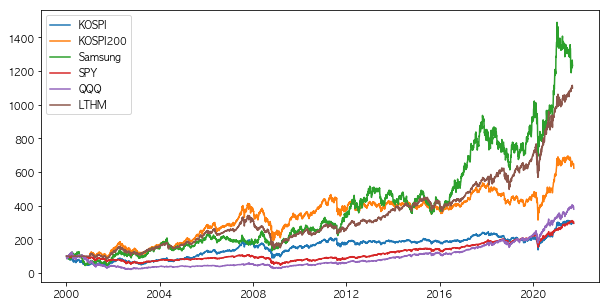

In [169]:
system.show_chart()

2021-10-03 20:26:46,456 - DEBUG - update_title_pos
2021-10-03 20:26:46,536 - DEBUG - update_title_pos
2021-10-03 20:26:46,575 - DEBUG - update_title_pos
2021-10-03 20:26:46,597 - DEBUG - update_title_pos


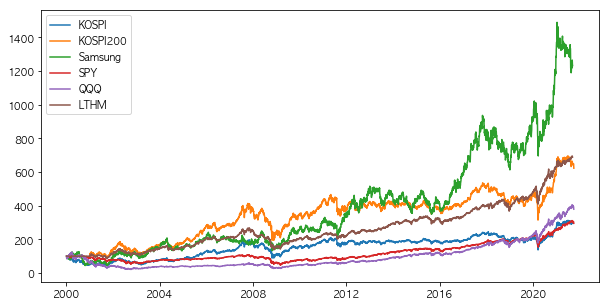

In [95]:
# 70%, 월1회 rebalance - 2000~2021
system.show_chart()

2021-10-03 20:28:10,336 - DEBUG - update_title_pos
2021-10-03 20:28:10,430 - DEBUG - update_title_pos
2021-10-03 20:28:10,482 - DEBUG - update_title_pos
2021-10-03 20:28:10,520 - DEBUG - update_title_pos


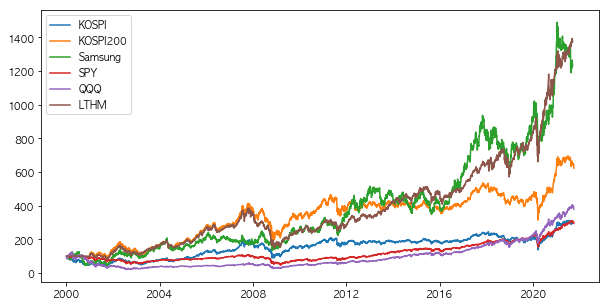

In [98]:
# 100%, 월1회 rebalance - 2000~2021
system.show_chart()